In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

# Load the dataset
df = pd.read_csv("qsar_fish_toxicity.csv")

# Display the first few rows of the dataframe
print("First few rows of the dataframe:")
df.head()


First few rows of the dataframe:


,CIC0,SM1_Dz(Z),GATS1i,NdsCH,NdssC,MLOGP,LC50 [-LOG(mol/L)]
0,3.260,0.829,1.676,0.0,1,1.453,3.770
1,2.189,0.580,0.863,0.0,0,1.348,3.115
2,2.125,0.638,0.831,0.0,0,1.348,3.531
3,3.027,0.331,1.472,1.0,0,1.807,3.510
4,2.094,0.827,0.860,0.0,0,1.886,5.390


### Insights:
#### ->LC50 data, which is the concentration that causes death in 50% of test fish over a test duration of 96 hours, was used as a model response. 
#### -> The data comprised 6 molecular descriptors: 
#### -> MLOGP (molecular properties), 
#### -> CIC0 (information indices), 
#### -> GATS1i (2D autocorrelations), 
#### -> NdssC (atom-type counts), 
#### -> NdsCH ((atom-type counts), 
##### -> SM1_Dz(Z) (2D matrix-based descriptors). 

In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 908 entries, 0 to 907
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   CIC0                906 non-null    float64
 1   SM1_Dz(Z)           906 non-null    float64
 2   GATS1i              906 non-null    float64
 3   NdsCH               907 non-null    float64
 4   NdssC               908 non-null    int64  
 5   MLOGP               905 non-null    float64
 6   LC50 [-LOG(mol/L)]  906 non-null    float64
dtypes: float64(6), int64(1)
memory usage: 49.8 KB


## Identification of missing values and it's treatment

In [3]:
df['SM1_Dz(Z)'] = df['SM1_Dz(Z)'].replace(0, np.nan)
print("No of missing values per columns are:")

df.isna().sum()


No of missing values per columns are:


CIC0                   2
SM1_Dz(Z)             38
GATS1i                 2
NdsCH                  1
NdssC                  0
MLOGP                  3
LC50 [-LOG(mol/L)]     2
dtype: int64

### This overall process can be referred to as Missing Data Handling through Identification and Imputation.

#### Reasons for This Type of Missing Value Identification
##### Identify Columns with Missing Values:
##### ->The code creates a list of columns that have any missing values, helping you focus on the columns that need attention.
#### Quantify Missing Values:
##### ->It counts the number of missing values in each column, giving you a clear picture of how much data is missing.
#### Prevent Data Loss:
##### ->By identifying which columns have missing values, you can choose imputation over deletion to avoid losing valuable data.
#### Informed Decision-Making:
##### ->Knowing the extent of missing data helps you decide on the best strategy for handling it, like different imputation methods for different columns.
#### Improving Model Quality:
##### ->Properly handling missing values ensures your models are trained on clean data, improving their performance.
#### Insight into Data Quality:
##### ->This process gives you an understanding of the overall data quality and helps identify any issues in the data collection process.

### The total number of missing values is: 2+38+2+1+0+3+2 = 48
### So, there are 48 missing values in total.

In [4]:
# Display the percentage of missing values in each column
print("Percentage of missing values in each column:")
print((df.isna().sum() / len(df)) * 100)

Percentage of missing values in each column:
CIC0                  0.220264
SM1_Dz(Z)             4.185022
GATS1i                0.220264
NdsCH                 0.110132
NdssC                 0.000000
MLOGP                 0.330396
LC50 [-LOG(mol/L)]    0.220264
dtype: float64


#### Why we use KNNImputer and what it is and when to use?

##### ->KNN imputer is a technique that replaces missing values in a dataset by averaging the values of its nearest neighbors, using similarity measures like Euclidean distance, making it effective for datasets where missing data are not systematically related to the values themselves.
##### ->KNN imputer is used for missing values because it estimates them based on similarities with neighboring data points, preserving data structure and handling non-linear relationships well. It's effective in moderate to large datasets where missingness is random, making it suitable when missing values are not related to their own values but to other observed variables.

In [5]:
from sklearn.impute import KNNImputer

imputer = KNNImputer(n_neighbors = 5)
df_noMV = imputer.fit_transform(df)

df_noMV = pd.DataFrame(df_noMV, columns = df.columns)

In [6]:
display(df_noMV.head())

df_noMV.isna().sum()

,CIC0,SM1_Dz(Z),GATS1i,NdsCH,NdssC,MLOGP,LC50 [-LOG(mol/L)]
0,3.260,0.829,1.676,0.0,1.0,1.453,3.770
1,2.189,0.580,0.863,0.0,0.0,1.348,3.115
2,2.125,0.638,0.831,0.0,0.0,1.348,3.531
3,3.027,0.331,1.472,1.0,0.0,1.807,3.510
4,2.094,0.827,0.860,0.0,0.0,1.886,5.390


CIC0                  0
SM1_Dz(Z)             0
GATS1i                0
NdsCH                 0
NdssC                 0
MLOGP                 0
LC50 [-LOG(mol/L)]    0
dtype: int64

### Checking for Normal Distribution

In [7]:
import scipy.stats as stats

# Function to perform Anderson-Darling Test
def anderson_darling_test(data, column):
    result = stats.anderson(data[column], dist='norm')
    print(f'Anderson-Darling Test for {column}:')
    print(f'Statistic: {result.statistic}')
    for i in range(len(result.critical_values)):
        sl, cv = result.significance_level[i], result.critical_values[i]
        if result.statistic < cv:
            print(f'At {sl}% significance level, the data looks normal (statistic {result.statistic} < critical value {cv}).')
        else:
            print(f'At {sl}% significance level, the data does not look normal (statistic {result.statistic} >= critical value {cv}).')
    print()

# List of numerical columns
numerical_cols = df_noMV.select_dtypes(include=['number']).columns.tolist()

# Perform the Anderson-Darling test for each numerical column
for column in numerical_cols:
    anderson_darling_test(df_noMV, column)


Anderson-Darling Test for CIC0:
Statistic: 1.3284591144893056
At 15.0% significance level, the data does not look normal (statistic 1.3284591144893056 >= critical value 0.573).
At 10.0% significance level, the data does not look normal (statistic 1.3284591144893056 >= critical value 0.653).
At 5.0% significance level, the data does not look normal (statistic 1.3284591144893056 >= critical value 0.784).
At 2.5% significance level, the data does not look normal (statistic 1.3284591144893056 >= critical value 0.914).
At 1.0% significance level, the data does not look normal (statistic 1.3284591144893056 >= critical value 1.087).

Anderson-Darling Test for SM1_Dz(Z):
Statistic: 17.706150148057077
At 15.0% significance level, the data does not look normal (statistic 17.706150148057077 >= critical value 0.573).
At 10.0% significance level, the data does not look normal (statistic 17.706150148057077 >= critical value 0.653).
At 5.0% significance level, the data does not look normal (statistic

### What is Anderson-Darling Test

#### ->The Anderson-Darling test is a statistical test used to determine if a given sample of data comes from a specific distribution, most commonly the normal distribution. It is an extension of the Kolmogorov-Smirnov test and provides a more sensitive measure of how well the data follows the hypothesized distribution.
#### ->Purpose: To test the null hypothesis that a sample comes from a specified distribution, such as the normal distribution.
#### ->Test Statistic: It calculates a test statistic that measures the distance between the empirical distribution of the sample data and the cumulative distribution function (CDF) of the specified distribution.


### Since the Dataset is not Normally Distributed, therefore we should use IQR instead of Z-score and DBSCAN for outlier detection

### Outlier Detection Using IQR

#### ->Here we are not considering NDsCH for outier detection because Because if we see the unique values, they are 0, 1, 2 and 3. And the count of the atom type can lie between 0 to 3( it is possible). So, 1, 2 or 3 are not at all outliers. However values like 20, or 50, or -3 can be treated as outlier as 20 or 50 is very far from the majority (0-3), and count of -3 is insignificant.


In [8]:
# Step 1: Identify numerical columns excluding 'NdsCH'
numerical_cols = df_noMV.select_dtypes(include=np.number).columns
numerical_cols = numerical_cols[numerical_cols != 'NdsCH']  # Exclude 'NdsCH'

# Step 2: Define a function to find outliers using IQR method
def find_outliers_iqr(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return lower_bound, upper_bound

# Step 3: Remove outliers from all numerical columns except 'NdsCH'
for column in numerical_cols:
    lower_bound, upper_bound = find_outliers_iqr(df_noMV, column)
    df_noMV = df_noMV[(df_noMV[column] >= lower_bound) & (df_noMV[column] <= upper_bound)]

# Display the new dataframe without outliers
print("DataFrame after removing outliers:")
print(df_noMV.head())

# Step 4: Verify the total number of rows after outlier removal
print(f"Total number of rows after outlier removal: {len(df_noMV)}")

DataFrame after removing outliers:
    CIC0  SM1_Dz(Z)  GATS1i  NdsCH  NdssC  MLOGP  LC50 [-LOG(mol/L)]
0  3.260      0.829   1.676    0.0    1.0  1.453               3.770
1  2.189      0.580   0.863    0.0    0.0  1.348               3.115
2  2.125      0.638   0.831    0.0    0.0  1.348               3.531
3  3.027      0.331   1.472    1.0    0.0  1.807               3.510
4  2.094      0.827   0.860    0.0    0.0  1.886               5.390
Total number of rows after outlier removal: 833


#### Why IQR is used in Outlier Detection

##### ->Given your dataset consists of only numerical attributes and you've identified outliers using multiple methods (DBSCAN, IQR, Z-score), here’s why IQR is particularly useful:
##### ->Balance Between Sensitivity and Robustness: The IQR method strikes a good balance between being sensitive enough to detect meaningful outliers and robust enough to avoid flagging too many points as outliers in skewed or non-normal distributions.
##### ->Compatibility with Median Imputation: Since you are replacing outliers with the median, using a method that relies on median and quartiles for outlier detection ensures consistency in your approach.

### Here total no of outliers is 79, and percentage of outlier is 8.70%

### Descriptive Statistics

In [9]:
# Display descriptive statistics
print("Descriptive Statistics:")
print(df_noMV.describe())

Descriptive Statistics:
             CIC0   SM1_Dz(Z)      GATS1i       NdsCH       NdssC       MLOGP  \
count  833.000000  833.000000  833.000000  833.000000  833.000000  833.000000   
mean     2.869394    0.625896    1.276315    0.216086    0.379352    2.119015   
std      0.728160    0.397947    0.374771    0.581262    0.641255    1.319043   
min      0.965000    0.134000    0.396000    0.000000    0.000000   -1.306000   
25%      2.309000    0.251000    0.945000    0.000000    0.000000    1.239000   
50%      2.888000    0.560000    1.227000    0.000000    0.000000    2.127000   
75%      3.380000    0.887000    1.556000    0.000000    1.000000    3.026000   
max      4.880000    1.825000    2.456000    4.000000    2.000000    5.741000   

       LC50 [-LOG(mol/L)]  
count          833.000000  
mean             4.002791  
std              1.275489  
min              0.778000  
25%              3.168000  
50%              3.971000  
75%              4.811000  
max              7.382

#### ->Descriptive statistics are used to summarize and describe the basic features of a dataset. It helps us understand the data by providing key numerical summaries such as measures of central tendency (like mean and median), measures of dispersion (like standard deviation and range), and distribution shape (like quartiles).

#### Observation:
#### CIC0:
##### ->The average value of CIC0 is around 2.90, with values ranging from 0.67 to 5.93.
##### ->Most values (about 50%) fall between 2.35 and 3.41.

#### SM1_Dz(Z):
##### ->SM1_Dz(Z) has a mean of approximately 0.65 and a standard deviation of 0.41.
##### ->Values range from 0.13 to 2.17, with half of the data falling between 0.25 and 0.91.

#### GATS1i:
##### ->The average GATS1i value is about 1.30, with a range from 0.40 to 4.98.
##### ->The data shows a moderate spread around the mean, with values mostly between 0.95 and 1.56.

#### NdsCH:
##### ->The average value of NdsCH is around 0.23, with values ranging from 0 to 4.
##### ->Most values (about 50%) fall between 0 and 0.

####  NdssC:
##### ->The average value of NdssC is around 0.50, with values ranging from -3 to 20.
##### ->Most values (about 50%) fall between 0 and 1.

#### MLOGP:
##### ->MLOGP has an average of 2.11 and ranges from -5.78 to 10.00.
##### ->The data is moderately spread out, with a significant proportion falling between 1.21 and 3.11.

#### LC50 [-LOG(mol/L)]:
##### ->LC50 values range widely from 0.053 to 9.612, with an average around 4.06.
##### ->There is variability in toxicity levels, with about half of the data falling between 3.15 and 4.91.

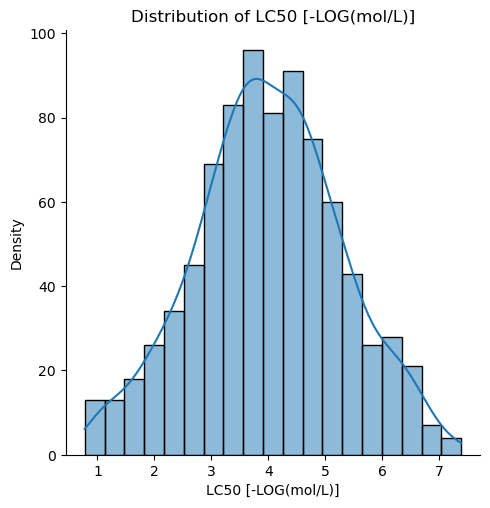

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot the distribution using Seaborn's displot
sns.displot(df_noMV['LC50 [-LOG(mol/L)]'], kde=True)

# Add title and labels
plt.title('Distribution of LC50 [-LOG(mol/L)]')
plt.xlabel('LC50 [-LOG(mol/L)]')
plt.ylabel('Density')

# Show the plot
plt.show()

#### The distribution plot of LC50 [-LOG(mol/L)] shows:
##### ->Normal Distribution: The histogram and KDE line form a bell-shaped curve, indicating a normal distribution.
##### ->Central Tendency: The peak is around 4 on the x-axis, suggesting this is the most common LC50 value.
##### ->Spread: Values range from approximately 1 to 7.
##### ->Density: The highest density is just above 100.
##### ->Symmetry: The distribution is fairly symmetric around the central value.
#### These observations indicate that the LC50 [-LOG(mol/L)] values follow a distribution that is approximately normal, with most values clustering around the mean of 4, and a relatively symmetrical spread on either side.

In [11]:
# check for multicollinearity
# Select only numerical columns for correlation matrix
numerical_cols = df_noMV.select_dtypes(include=['float64', 'int64'])
correlation_matrix = numerical_cols.corr()

print(correlation_matrix)

                        CIC0  SM1_Dz(Z)    GATS1i     NdsCH     NdssC  \
CIC0                1.000000  -0.251924  0.190152  0.059808  0.191028   
SM1_Dz(Z)          -0.251924   1.000000 -0.184905 -0.112378  0.101348   
GATS1i              0.190152  -0.184905  1.000000  0.006341  0.138022   
NdsCH               0.059808  -0.112378  0.006341  1.000000  0.131294   
NdssC               0.191028   0.101348  0.138022  0.131294  1.000000   
MLOGP               0.444141   0.256457 -0.414401 -0.014024 -0.023198   
LC50 [-LOG(mol/L)]  0.243637   0.456457 -0.375628  0.148638  0.052674   

                       MLOGP  LC50 [-LOG(mol/L)]  
CIC0                0.444141            0.243637  
SM1_Dz(Z)           0.256457            0.456457  
GATS1i             -0.414401           -0.375628  
NdsCH              -0.014024            0.148638  
NdssC              -0.023198            0.052674  
MLOGP               1.000000            0.658332  
LC50 [-LOG(mol/L)]  0.658332            1.000000  


### Multicollinearity refers to the phenomenon where two or more predictor variables in a regression model are highly correlated with each other. It can lead to issues in the regression analysis, primarily affecting the interpretation of individual predictor variables.

### All correlation values are below 0.9, indicating no significant multicolinearity amog attributes hence no need to remove anything

In [12]:
df_new = df_noMV

### Splitting of the dataset as per 80% training and 20% testing.

In [13]:
X = df_new .drop('LC50 [-LOG(mol/L)]',axis =1)
y = df_new['LC50 [-LOG(mol/L)]']

from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.20,random_state=100)

### Here I took random state of 100

## Performing Regression Model 

## 1.Ridge Regression

#### Ridge regression is used because:
##### ->Improving the stability and generalization of regression models.
##### ->Offering a solution to overfitting by shrinking the coefficients towards zero
##### ->ridge regression addresses the trade-off between bias and variance by slightly increasing bias 

In [14]:
import numpy as np
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Define the lambda range
lamda = np.linspace(0, 1, 20)

# Initialize best parameters
best_lamda = 0
best_mae = float('inf')  # Initialize to a high value
best_mse = float('inf')  # Initialize to a high value
best_r2 = float('-inf')  # Initialize to a low value
best_adjr2 = float('-inf')  # Initialize to a low value

# Train and evaluate the Ridge regression model for each lambda
for param in lamda:
    RRM = Ridge(alpha=param)
    RRM.fit(X_train, y_train)

    y_pred = RRM.predict(X_test)
    
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    adjusted_r2 = 1 - (1-r2) * (len(y_test) - 1) / (len(y_test) - X_test.shape[1] - 1)
    
    print(f"lambda = {param}")
    print(f"MAE for this lambda = {mae}")
    print(f"MSE for this lambda = {mse}")
    print(f"R² for this lambda = {r2}")
    print(f"Adjusted R² for this lambda = {adjusted_r2}")
    print("------------------")

    if mae < best_mae:
        best_mae = mae
        best_lamda = param

    if mse < best_mse:
        best_mse = mse
        best_lamda = param

    if r2 > best_r2:
        best_r2 = r2
        best_lamda = param

    if adjusted_r2 > best_adjr2:
        best_adjr2 = adjusted_r2
        best_lamda = param

print(f"Best value of lambda = {best_lamda}")
print(f"Best value of MAE for the best lambda = {best_mae}")
print(f"Best value of MSE for the best lambda = {best_mse}")
print(f"Best value of R² for the best lambda = {best_r2}")
print(f"Best value of Adjusted R² for the best lambda = {best_adjr2}")


lambda = 0.0
MAE for this lambda = 0.5581142428327338
MSE for this lambda = 0.552629475115506
R² for this lambda = 0.627445940710041
Adjusted R² for this lambda = 0.6134751634866675
------------------
lambda = 0.05263157894736842
MAE for this lambda = 0.5581700136170352
MSE for this lambda = 0.552656668499766
R² for this lambda = 0.6274276083442369
Adjusted R² for this lambda = 0.6134561436571458
------------------
lambda = 0.10526315789473684
MAE for this lambda = 0.5582256542175964
MSE for this lambda = 0.5526840997465032
R² for this lambda = 0.627409115623918
Adjusted R² for this lambda = 0.6134369574598149
------------------
lambda = 0.15789473684210525
MAE for this lambda = 0.5582811650601603
MSE for this lambda = 0.5527117672224401
R² for this lambda = 0.6273904636501548
Adjusted R² for this lambda = 0.6134176060370357
------------------
lambda = 0.21052631578947367
MAE for this lambda = 0.5583365465686139
MSE for this lambda = 0.5527396693052228
R² for this lambda = 0.6273716535

#### Observation:
#### Best Lambda Value: 0.0
##### ->The optimal value of lambda (regularization parameter) found through the Ridge regression is 0.0. This implies no regularization was applied, allowing the model to fit the data without penalty on coefficients.
#### Best MAE: 0.5581
##### ->The MAE for the best lambda is 0.5581. This value indicates the average absolute difference between the predicted and actual values. A lower MAE suggests better predictive accuracy, indicating that, on average, the model's predictions are close to the actual values.
#### Best MSE: 0.5526
##### ->Mean Squared Error (MSE): The MSE for the best lambda is 0.5526. MSE measures the average squared difference between predicted values and actual values. A lower MSE indicates better predictive accuracy, suggesting that the model's predictions are generally closer to the actual values.
#### Best R²: 0.6274
##### ->The R² score for the best lambda is 0.6274. R² measures the proportion of the variance in the dependent variable that is predictable from the independent variables. An R² of 0.6274 indicates that approximately 62.74% of the variability in the target variable is explained by the model. This indicates a strong fit of the model to the data.
#### Best Adjusted R²: 0.6135
##### ->The adjusted R² for the best lambda is 0.6135. Adjusted R² adjusts the R² value based on the number of predictors in the model, providing a more accurate measure of model performance. It accounts for the complexity added by additional predictors, showing a slightly more conservative estimate of the model's explanatory power.
#### Final Verdict:
##### ->Model Selection: The Ridge regression with a lambda of 0.0 was selected as the best model, indicating that no regularization was necessary to achieve optimal performance.
##### ->Predictive Accuracy: The low MAE and MSE suggests that the model's predictions are generally close to the actual values, demonstrating good predictive accuracy.
##### ->Explanatory Power: The high R² and adjusted R² values indicate that the model explains a significant proportion of the variance in the target variable, reflecting its strong fit to the data.

## 2.Multiple Linear Regression:

##### ->Used for assumption of Linearity and Independence
##### ->Modeling Relationships Between Several Variables
##### ->Used when Predicting a Continuous Dependent Variable

In [15]:
from sklearn.linear_model import LinearRegression

# model fitting
lm = LinearRegression()
lm.fit(X_train,y_train)

#predict the outcomes
y_pred = lm.predict(X_test)

coefficients = pd.DataFrame(lm.coef_,X.columns)
coefficients.columns = ['coefficients']
display(coefficients)

print("intercept is {}".format(lm.intercept_))

,coefficients
CIC0,0.309702
SM1_Dz(Z),1.231031
GATS1i,-0.541997
NdsCH,0.426648
NdssC,-0.014038
MLOGP,0.400795


intercept is 2.094450836617983


In [16]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
# Calculate R²
r2 = r2_score(y_test, y_pred)

# Calculate Adjusted R²
adjusted_r2 = 1 - (1-r2) * (len(y_test)-1) / (len(y_test)-X_test.shape[1]-1)

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, y_pred)

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_pred)

# Print the model performance metrics
print(f"R²: {r2}")
print(f"Adjusted R²: {adjusted_r2}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")


R²: 0.6274459407100411
Adjusted R²: 0.6134751634866676
Mean Absolute Error (MAE): 0.5581142428327335
Mean Squared Error (MSE): 0.5526294751155058


#### Observation:
#### R² (Coefficient of Determination): 0.6274
##### ->his indicates that approximately 62.74% of the variance in the dependent variable is explained by the independent variables in the model. This is a substantial proportion, showing a strong fit to the data.
#### Adjusted R²: 0.6135
##### ->This value is adjusted for the number of predictors in the model and is slightly lower than R², indicating that not all independent variables significantly contribute to the model. It provides a more conservative estimate of the model's explanatory power, accounting for the complexity of the model.
#### Mean Absolute Error (MAE): 0.5581
##### ->On average, the model's predictions are 0.5581 units away from the actual values, showing the average magnitude of errors in the predictions. A lower MAE indicates better predictive accuracy, suggesting that the model's predictions are generally close to the actual values.
#### Mean Squared Error (MSE): 0.5531
##### ->The Mean Squared Error (MSE) for the model is 0.5532. MSE quantifies the average squared difference between predicted values and actual values. A lower MSE indicates that, on average, the model's predictions are closer to the actual values, demonstrating effective predictive accuracy in minimizing errors.

#### These metrics suggest that the model explains a substantial proportion of the variance (R² and Adjusted R²) and has a relatively low average error (MAE) and squared error (MSE), indicating strong predictive accuracy. While the fit is good, there may still be room for improvement in prediction accuracy and further reduction in errors.

## 3.Lasso Regression

##### ->It facilitates feature selection by shrinking less important features' coefficients to zero.
##### ->Acts as a regularization method to prevent overfitting by penalizing large coefficients.
##### ->Effectively handles multicollinearity by shrinking coefficients of correlated predictors, improving model stability and interpretability.

In [17]:
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
# Define the range of lambda (alpha) values
lamda = np.linspace(0.001, 0.05, 10)

best_lamda = 0
best_mae = float('inf')  # Initialize with a large value for finding minimum
best_mse = float('inf')  # Initialize with a large value for finding minimum
best_r2 = -float('inf')   # Initialize with a large negative value for finding maximum
best_adjr2 = -float('inf') # Initialize with a large negative value for finding maximum

for param in lamda:
    # Create Lasso Regression model with current alpha parameter
    LRM = Lasso(alpha=param)
    LRM.fit(X_train, y_train)
    
    # Predict using the model
    y_pred = LRM.predict(X_test)
    
    # Calculate evaluation metrics
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    n = len(y_test)
    p = X_test.shape[1]
    adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)
    
    # Print metrics for current lambda
    print("lambda =", param)
    print("MAE for this lambda =", mae)
    print("MSE for this lambda =", mse)
    print("R² for this lambda =", r2)
    print("Adjusted R² for this lambda =", adjusted_r2)
    print("------------------")
    
    # Update best metrics and lambda if a better value is found
    if mae < best_mae:
        best_mae = mae
        best_lamda = param
    
    if mse < best_mse:
        best_mse = mse
        best_lamda = param
    
    if r2 > best_r2:
        best_r2 = r2
        best_lamda = param
    
    if adjusted_r2 > best_adjr2:
        best_adjr2 = adjusted_r2
        best_lamda = param

# Print the best lambda and corresponding metrics found
print("Best value of lambda =", best_lamda)
print("Best MAE =", best_mae)
print("Best MSE =", best_mse)
print("Best R² =", best_r2)
print("Best Adjusted R² =", best_adjr2)


lambda = 0.001
MAE for this lambda = 0.559312318400772
MSE for this lambda = 0.5532447278772145
R² for this lambda = 0.6270311692868991
Adjusted R² for this lambda = 0.6130448381351578
------------------
lambda = 0.0064444444444444445
MAE for this lambda = 0.5639586183646867
MSE for this lambda = 0.5567888094935342
R² for this lambda = 0.6246419337284104
Adjusted R² for this lambda = 0.6105660062432258
------------------
lambda = 0.01188888888888889
MAE for this lambda = 0.5686344216992294
MSE for this lambda = 0.5616433430620987
R² for this lambda = 0.6213692595979724
Adjusted R² for this lambda = 0.6071706068328964
------------------
lambda = 0.017333333333333333
MAE for this lambda = 0.5737543100947852
MSE for this lambda = 0.5683318310122312
R² for this lambda = 0.6168602287761672
Adjusted R² for this lambda = 0.6024924873552735
------------------
lambda = 0.02277777777777778
MAE for this lambda = 0.5790584441105241
MSE for this lambda = 0.5768441666303001
R² for this lambda = 0.61

#### Observation:
#### Best Lambda: 0.001
##### ->The optimal regularization strength (lambda) selected for the Lasso regression model is 0.001. This indicates a low level of regularization, which helps to improve generalization while minimally penalizing coefficients.
#### Best MAE: 0.5593
##### ->The mean absolute error achieved by the model on the test set is 0.5593. Lower MAE values indicate better predictive accuracy, suggesting that the model's predictions are generally close to the actual values.
#### Best MSE: 0.5532
##### ->The best Mean Squared Error (MSE) achieved by the Lasso regression model is 0.5532. This indicates that, on average, the squared difference between the model's predictions and the actual values is relatively low, suggesting effective predictive accuracy in minimizing prediction errors.
#### Best R²: 0.6270
##### ->The coefficient of determination of 0.6270 suggests that approximately 62.70% of the variance in the dependent variable is explained by the independent variables included in the model. Higher R² values indicate a better fit to the data.
#### Best Adjusted R²: 0.6130
##### ->The adjusted R² of 0.6130 accounts for the number of predictors in the model, showing a slightly lower but more conservative estimate of model fit compared to R². It helps in assessing the model's goodness-of-fit considering the complexity added by additional predictors.
##### ->These results demonstrate a balanced trade-off achieved by tuning the regularization strength (lambda). The model shows good predictive accuracy (MAE) and a high level of explained variance (R²), suggesting effective regularization to prevent overfitting while maintaining strong predictive power.








## 4.ElasticNet Regression

##### ->Elastic Net regression is a regularization technique that combines the penalties of both Lasso (L1 norm) and Ridge (L2 norm) regression. Let's delve into each type to understand how Elastic Net differs from Lasso, Ridge, and Multiple Linear Regression:

#### When to choose Elasticnet Regression?
##### ->Elastic Net regression is often preferred in situations where there are many correlated predictors. It helps to address the limitations of Lasso, which may select only one variable from a group of highly correlated variables, by incorporating Ridge's ability to handle multicollinearity. This makes Elastic Net more robust and versatile in many real-world scenarios where datasets often exhibit complex relationships among variables.

In [18]:
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
# Define the range of alpha (regularization strength) and l1_ratio values
alpha_values = np.linspace(0.001, 0.05, 10)
l1_ratio_values = [0.1, 0.3, 0.5, 0.7, 0.9]  # Adjust as needed

best_alpha = 0
best_l1_ratio = 0
best_mae = float('inf')  # Initialize with a large value for finding minimum
best_mse = float('inf')  # Initialize with a large value for finding minimum
best_r2 = -float('inf')   # Initialize with a large negative value for finding maximum
best_adjr2 = -float('inf') # Initialize with a large negative value for finding maximum

for alpha_param in alpha_values:
    for l1_ratio_param in l1_ratio_values:
        # Create ElasticNet Regression model with current alpha and l1_ratio parameters
        ENM = ElasticNet(alpha=alpha_param, l1_ratio=l1_ratio_param)
        ENM.fit(X_train, y_train)
        
        # Predict using the model
        y_pred = ENM.predict(X_test)
        
        # Calculate evaluation metrics
        mae = mean_absolute_error(y_test, y_pred)
        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        n = len(y_test)
        p = X_test.shape[1]
        adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)
        
        # Print metrics for current alpha and l1_ratio
        print("alpha =", alpha_param)
        print("l1_ratio =", l1_ratio_param)
        print("MAE for this combination =", mae)
        print("MSE for this combination =", mse)
        print("R² for this combination =", r2)
        print("Adjusted R² for this combination =", adjusted_r2)
        print("------------------")
        
        # Update best metrics and parameters if a better combination is found
        if mae < best_mae:
            best_mae = mae
            best_alpha = alpha_param
            best_l1_ratio = l1_ratio_param
        
        if mse < best_mse:
            best_mse = mse
            best_alpha = alpha_param
            best_l1_ratio = l1_ratio_param
        
        if r2 > best_r2:
            best_r2 = r2
            best_alpha = alpha_param
            best_l1_ratio = l1_ratio_param
        
        if adjusted_r2 > best_adjr2:
            best_adjr2 = adjusted_r2
            best_alpha = alpha_param
            best_l1_ratio = l1_ratio_param

# Print the best parameters and corresponding metrics found
print("Best value of alpha =", best_alpha)
print("Best value of l1_ratio =", best_l1_ratio)
print("Best MAE =", best_mae)
print("Best MSE =", best_mse)
print("Best R² =", best_r2)
print("Best Adjusted R² =", best_adjr2)


alpha = 0.001
l1_ratio = 0.1
MAE for this combination = 0.5588486270291629
MSE for this combination = 0.5530103868428016
R² for this combination = 0.62718914982822
Adjusted R² for this combination = 0.6132087429467783
------------------
alpha = 0.001
l1_ratio = 0.3
MAE for this combination = 0.5589510743855782
MSE for this combination = 0.5530606856719668
R² for this combination = 0.6271552409727811
Adjusted R² for this combination = 0.6131735625092604
------------------
alpha = 0.001
l1_ratio = 0.5
MAE for this combination = 0.5590538597157276
MSE for this combination = 0.5531119923442114
R² for this combination = 0.6271206526819386
Adjusted R² for this combination = 0.6131376771575113
------------------
alpha = 0.001
l1_ratio = 0.7
MAE for this combination = 0.5591569855577296
MSE for this combination = 0.5531643158874329
R² for this combination = 0.6270853788695537
Adjusted R² for this combination = 0.613101080577162
------------------
alpha = 0.001
l1_ratio = 0.9
MAE for this combi

#### Observation
#### Best Alpha: 0.001
##### ->The optimal regularization strength (alpha) for the ElasticNet regression model is 0.001, balancing L1 (Lasso) and L2 (Ridge) penalties to prevent overfitting while maintaining model flexibility.
#### Best L1 Ratio: 0.1
##### ->The L1 ratio (l1_ratio) of 0.1 indicates a slight preference for L2 regularization, suggesting a stronger emphasis on Ridge regularization over Lasso.
#### Best MAE: 0.5588
##### ->The mean absolute error (MAE) achieved by the model on the test set is 0.5588. Lower MAE values indicate better predictive accuracy, showing that the model's predictions are generally close to the actual values.
#### Best MAE: 0.5530
##### ->The best Mean Squared Error (MSE) obtained by the ElasticNet regression model is 0.5530, indicating strong predictive accuracy with minimized prediction errors.
#### Best R²: 0.6272
##### ->The coefficient of determination (R²) of 0.6272 indicates that approximately 62.72% of the variance in the dependent variable is explained by the independent variables included in the model. Higher R² values indicate better fit to the data.
#### Best Adjusted R²: 0.6132
##### ->The adjusted R² of 0.6132 adjusts for the number of predictors in the model, providing a slightly more conservative estimate of model fit compared to R². It reflects the model's ability to explain variability in the dependent variable while considering the complexity of the model.

In [19]:
import pandas as pd

# Define the data for each regression model
data = {
    'Regression Model': ['Elastic Net', 'Lasso Regression', 'Multiple Linear Regression', 'Ridge Regression'],
    'Best λ (if applicable)': [0.001, 0.001, 0.0, 0.0],
    'Best α or l1_ratio': [0.1, None, None, None],
    'MAE': [0.559312318400772, 0.5591520317827925, 0.5581142428327338, 0.5581142428327338],
    'MSE': [0.5532447278772145, 0.553185282666958, 0.552629475115506, 0.552629475115506],
    'R²': [0.6270311692868991, 0.6270712441569224, 0.627445940710041, 0.627445940710041],
    'Adjusted R²': [0.6130448381351578, 0.613086415812807, 0.6134751634866675,0.6134751634866675]
}

# Create a DataFrame
per = pd.DataFrame(data)

# Set the index to 'Regression Model' column
per.set_index('Regression Model', inplace=True)

# Display the DataFrame
per





,Best λ (if applicable),Best α or l1_ratio,MAE,MSE,R²,Adjusted R²
Regression Model,,,,,,
Elastic Net,0.001,0.1,0.559312,0.553245,0.627031,0.613045
Lasso Regression,0.001,NaN,0.559152,0.553185,0.627071,0.613086
Multiple Linear Regression,0.000,NaN,0.558114,0.552629,0.627446,0.613475
Ridge Regression,0.000,NaN,0.558114,0.552629,0.627446,0.613475


#### Based on the metrics provided (R², Adjusted R², MSE and MAE), Multiple Linear Regression and Ridge Regression seems to be the most favorable choice:

##### ->It has the highest R² and Adjusted R² among the models, indicating better explanatory power.
##### ->It also has the lowest MAE and MSE, suggesting more accurate predictions on average.
##### ->Therefore, Multiple Linear Regression and Ridge Regression appears to strike a good predictive performance in the dataset.

### Performing Classificcation Model

#### Creating a new column for the continous value LC50 to convert it into categorical value as classification can't be performed on continous values so a new categorical column is created from that particular column and categorised as Less, Medium and High Toxic respectively

#### Categorising as per the info LC50 data, which is the concentration that causes death in 50% of test fish over a test duration of 96 hours, was used as a model response.
##### ->Less Toxic: LC50 values from 6 to 10
##### ->Medium Toxic: LC50 values from 4 to 6
##### ->Highly Toxic: LC50 values from 1 to 4
#### These ranges provide a general guideline for categorizing the toxicity based on LC50 values.

In [20]:
# Define a function to categorize LC50 values
def categorize_toxicity(lc50):
    if lc50 >= 6:
        return "Less Toxic"
    elif 4 <= lc50 < 6:
        return "Medium Toxic"
    else:
        return "Highly Toxic"

# Apply the function to the LC50 column to create a new categorical column
df_new['Toxicity Category'] = df_new['LC50 [-LOG(mol/L)]'].apply(categorize_toxicity)

# Drop the 'LC50 [-LOG(mol/L)]' column from df_new
df_new.drop(columns=['LC50 [-LOG(mol/L)]'], inplace=True)

# Display the first few rows of the dataframe with the new Toxicity Category
print("First few rows of the dataframe with the new Toxicity Category:")
df_new.head()



First few rows of the dataframe with the new Toxicity Category:


,CIC0,SM1_Dz(Z),GATS1i,NdsCH,NdssC,MLOGP,Toxicity Category
0,3.260,0.829,1.676,0.0,1.0,1.453,Highly Toxic
1,2.189,0.580,0.863,0.0,0.0,1.348,Highly Toxic
2,2.125,0.638,0.831,0.0,0.0,1.348,Highly Toxic
3,3.027,0.331,1.472,1.0,0.0,1.807,Highly Toxic
4,2.094,0.827,0.860,0.0,0.0,1.886,Medium Toxic


#### Here I am dropping LC50 col because since it will create high colinearity so I have created a categorical column Toxicity category using the values of LC50 and using it for classification algorithm as it is a categorical value.

In [21]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
Index: 833 entries, 0 to 906
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   CIC0               833 non-null    float64
 1   SM1_Dz(Z)          833 non-null    float64
 2   GATS1i             833 non-null    float64
 3   NdsCH              833 non-null    float64
 4   NdssC              833 non-null    float64
 5   MLOGP              833 non-null    float64
 6   Toxicity Category  833 non-null    object 
dtypes: float64(6), object(1)
memory usage: 52.1+ KB


In [22]:
# Ensure column names are trimmed of any extra spaces
df_new.columns = df_new.columns.str.strip()

# Drop the 'Toxicity Category' column correctly
X = df_new.drop('Toxicity Category', axis=1)
y = df_new['Toxicity Category']

# Proceed with train-test split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100)


## 1.Naive Bayes

#### Naive Bayes is used in 
##### ->It is used in scenarios where simplicity, speed, and efficiency are valued, and where the assumption of feature independence (though naive) does not severely impact predictive accuracy. Their effectiveness in text classification, real-time applications, and multiclass prediction makes them a practical choice in many machine learning applications.

In [23]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.naive_bayes import GaussianNB

nb = GaussianNB() 
nb=nb.fit(X_train,y_train)
y_pred = nb.predict(X_test)

print("Model Performance metrics are as below :-\n")
print("Accuracy is "+str(accuracy_score(y_test,y_pred)))
print("Precision is "+str(precision_score(y_test,y_pred, average='weighted')))
print("Recall is "+str(recall_score(y_test,y_pred, average='weighted')))
print("F1-Score is "+str(f1_score(y_test,y_pred, average='weighted')))

Model Performance metrics are as below :-

Accuracy is 0.7485029940119761
Precision is 0.7449430144040923
Recall is 0.7485029940119761
F1-Score is 0.7450574725666925


#### Observation:
##### ->Accuracy: An accuracy of 0.7485 means that approximately 78.85% of the predictions made by your model on the test set were correct. 
##### ->Precision: Precision measures the proportion of true positive predictions out of all positive predictions made by the model. A precision of 0.744 means that when your model predicts a class (e.g., a toxicity category), it is correct about 74.4.5% of the time.
##### ->Recall: Recall (or sensitivity) measures the proportion of true positive instances that were correctly predicted by the model out of all actual positive instances. A recall of 0.7485 means that your model correctly identified approximately 74.8% of all actual positive instances in the dataset.
##### ->F1-Score: The F1-Score is the harmonic mean of precision and recall. It provides a single metric that balances both precision and recall. A high F1-Score (0.7450 in your case) indicates good overall performance, especially when you want to balance both precision and recall.
#### Final Verdict:
##### ->In summary, your model is performing well across these metrics, indicating strong predictive capability for the toxicity categories in your dataset. These metrics collectively provide a comprehensive evaluation of your model's performance, addressing both correctness and completeness in predictions.

### Adaboosting on Naive Bayes
##### ->Adaboosting enhances Naive Bayes by iteratively improving classification accuracy through focusing on misclassified instances, making it effective for handling complex relationships, improving accuracy, and addressing class imbalance in datasets.

In [24]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier

# Range of n_estimators
n_estimators_range = range(2, 51, 2)

# Store results for different n_estimators values
results = {
    'n_estimators': [],
    'accuracy': [],
    'precision': [],
    'recall': [],
    'f1_score': []
}

best_f1_score = -1
best_n_estimators = None

for n in n_estimators_range:
    base_estimator = GaussianNB()
    ada = AdaBoostClassifier(estimator=base_estimator, n_estimators=n, random_state=99, algorithm='SAMME')

    # Fit the model
    ada.fit(X_train, y_train)

    # Predict the test set results
    y_pred = ada.predict(X_test)

    # Evaluate model performance
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)

    # Store the results
    results['n_estimators'].append(n)
    results['accuracy'].append(accuracy)
    results['precision'].append(precision)
    results['recall'].append(recall)
    results['f1_score'].append(f1)

    # Track the best performing n_estimators
    if f1 > best_f1_score:
        best_f1_score = f1
        best_n_estimators = n

# Print the results for the best performing n_estimators
print(f"Best n_estimators = {best_n_estimators}:")
print(f"  Accuracy: {results['accuracy'][results['n_estimators'].index(best_n_estimators)]:.4f}")
print(f"  Precision: {results['precision'][results['n_estimators'].index(best_n_estimators)]:.4f}")
print(f"  Recall: {results['recall'][results['n_estimators'].index(best_n_estimators)]:.4f}")
print(f"  F1-Score: {results['f1_score'][results['n_estimators'].index(best_n_estimators)]:.4f}")


Best n_estimators = 2:
  Accuracy: 0.7485
  Precision: 0.7449
  Recall: 0.7485
  F1-Score: 0.7451


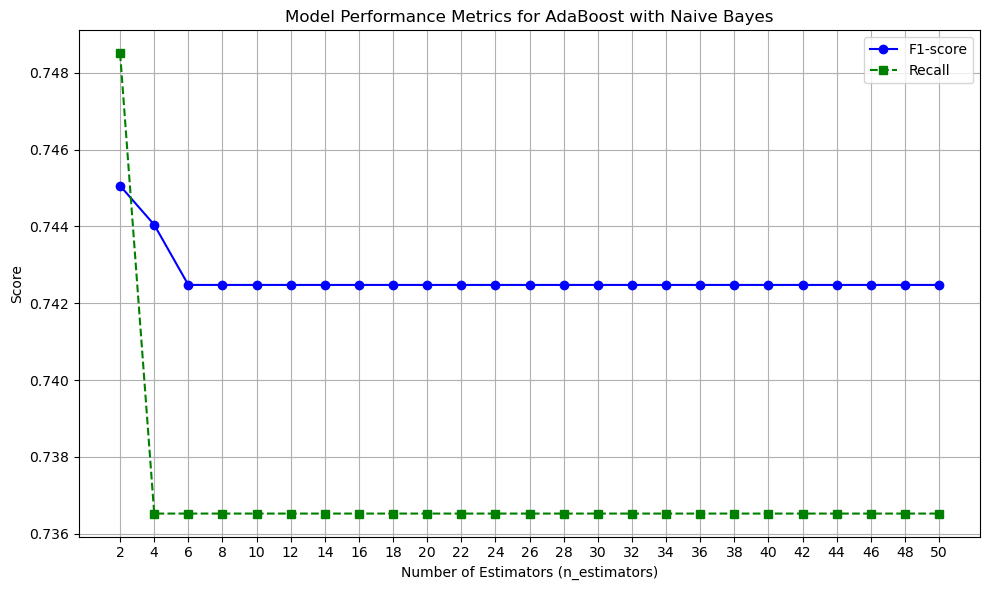

In [25]:
# Plotting F1-score and recall against n_estimators
plt.figure(figsize=(10, 6))

# Plot F1-score
plt.plot(results['n_estimators'], results['f1_score'], marker='o', linestyle='-', color='b', label='F1-score')

# Plot recall
plt.plot(results['n_estimators'], results['recall'], marker='s', linestyle='--', color='g', label='Recall')

plt.xlabel('Number of Estimators (n_estimators)')
plt.ylabel('Score')
plt.title('Model Performance Metrics for AdaBoost with Naive Bayes')
plt.xticks(range(2, 51, 2))
plt.grid(True)
plt.legend()
plt.tight_layout()

# Display the plot
plt.show()

#### The best value is at n = 2.

#### Observation:
##### ->Accuracy: AdaBoost (0.7485) is higher than Naive Bayes (0.7485).
##### ->Precision: AdaBoost (0.7449) is higher than Naive Bayes (0.7449).
##### ->Recall: AdaBoost (0.7485) is higher than Naive Bayes (0.7485).
##### ->F1-Score: AdaBoost (0.7451) is higher than Naive Bayes (0.7450).
#### Conclusion
##### ->The AdaBoost model with n_estimators = 2 outperforms the Naive Bayes model in F1-Score:
#### Therefore, the AdaBoost model with at least 2 estimators is the better choice compared to the Naive Bayes model based on the provided metrics

### K-Fold Cross Validation on Naive Bayes 
##### ->K-fold cross-validation is applied to Naive Bayes to evaluate its predictive performance across multiple subsets of the data, ensuring that the model's accuracy and generalization capability are reliably assessed without overfitting to any single training-validation split.

In [26]:
import numpy as np
from sklearn.model_selection import KFold, cross_val_predict
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.naive_bayes import GaussianNB

# Custom scoring function to handle zero division
def custom_precision(y_true, y_pred):
    try:
        return precision_score(y_true, y_pred, average='macro')
    except ZeroDivisionError:
        return 0.0

def custom_recall(y_true, y_pred):
    try:
        return recall_score(y_true, y_pred, average='macro')
    except ZeroDivisionError:
        return 0.0

def custom_f1(y_true, y_pred):
    try:
        return f1_score(y_true, y_pred, average='macro')
    except ZeroDivisionError:
        return 0.0

# Store results for different k values
results = {
    'k': [],
    'accuracy': [],
    'precision': [],
    'recall': [],
    'f1_score': []
}

# Convert string labels to numeric labels if needed
# Example:
# y_numeric = np.where(y == 'Highly Toxic', 0, np.where(y == 'Less Toxic', 1, 2))

for k in range(2, 20):
    kf = KFold(n_splits=k, shuffle=True, random_state=99)
    nb = GaussianNB()

    # Perform cross-validation prediction
    y_pred = cross_val_predict(nb, X, y, cv=kf)

    # Calculate metrics
    accuracy = accuracy_score(y, y_pred)
    precision = custom_precision(y, y_pred)
    recall = custom_recall(y, y_pred)
    f1 = custom_f1(y, y_pred)

    results['k'].append(k)
    results['accuracy'].append(accuracy)
    results['precision'].append(precision)
    results['recall'].append(recall)
    results['f1_score'].append(f1)

# Print the results
print("Model Performance metrics using k-Fold Cross Validation for different k values:\n")
best_index = np.argmax(results['f1_score'])
print(f"k = {results['k'][best_index]}:")
print(f"  Accuracy: {results['accuracy'][best_index]:.4f}")
print(f"  Precision: {results['precision'][best_index]:.4f}")
print(f"  Recall: {results['recall'][best_index]:.4f}")
print(f"  F1-Score: {results['f1_score'][best_index]:.4f}")


Model Performance metrics using k-Fold Cross Validation for different k values:

k = 15:
  Accuracy: 0.7263
  Precision: 0.6037
  Recall: 0.5598
  F1-Score: 0.5690


#### Observation:
##### ->Accuracy: K-Fold Cross (0.7263) is lower than Naive Bayes (0.7485).
##### ->Precision: K-Fold Cross (0.6037) is lower than Naive Bayes (0.7449).
##### ->Recall: K-Fold Cross (0.5592) is lower than Naive Bayes (0.7485).
##### ->F1-Score: K-Fold Cross (0.5690) is lower than Naive Bayes (0.7450).
#### Conclusion:
##### ->Therefore, Naive Bayes model based on the provided metrics is a better model.

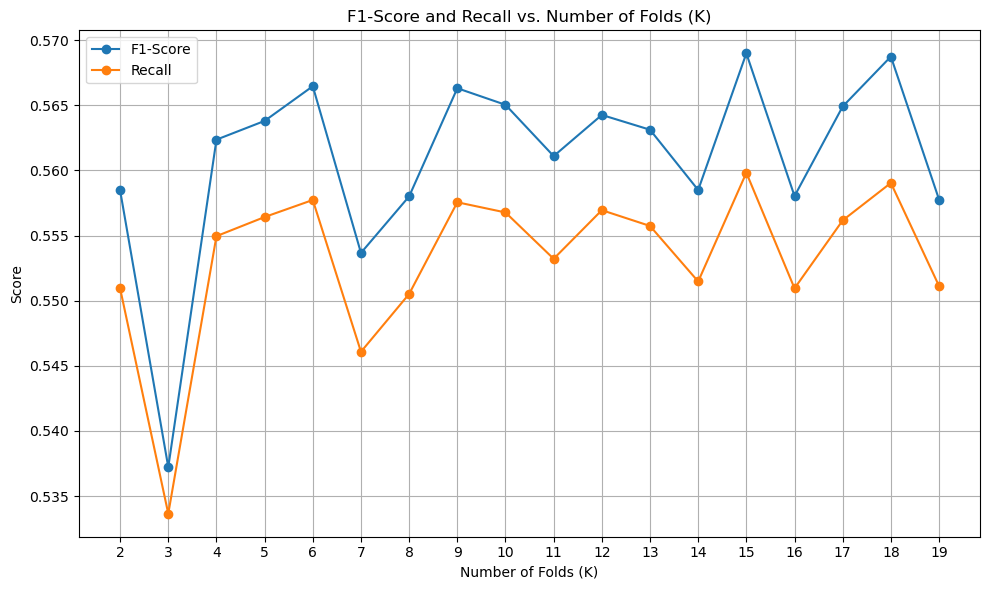

In [27]:
# Plotting F1-score and recall against k
plt.figure(figsize=(10, 6))
plt.plot(results['k'], results['f1_score'], marker='o', label='F1-Score')
plt.plot(results['k'], results['recall'], marker='o', label='Recall')
plt.title('F1-Score and Recall vs. Number of Folds (K)')
plt.xlabel('Number of Folds (K)')
plt.ylabel('Score')
plt.xticks(results['k'])
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

#### The best value is at k = 15, F1-score is also high,

#### So out of K fold cross, Naive Bayes and AdaBoost we should choose AdaBoost as it gives all the performance matrix best.

## 2.Support Vector Machine(SVM)

#### WHy we use SVM ?
##### ->When Dealing with High-Dimensional Data
##### ->When the Data is Sparse
##### ->When a Clear Margin of Separation Exists

In [28]:
from sklearn import svm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

kernel_values = ['linear', 'poly', 'rbf', 'sigmoid']

svm_clf = svm.SVC(kernel=kernel_values[0], C=1, gamma=0.1)

# Train SVC on X_train
svm_clf.fit(X_train, y_train)

# Predict the response using SVM fitted model
y_pred = svm_clf.predict(X_test)

# Calculate performance metrics
print("Model Performance metrics are as below :-\n")
print("Accuracy is " + str(accuracy_score(y_test, y_pred)))
print("Precision is " + str(precision_score(y_test, y_pred, average='weighted', zero_division=0)))
print("Recall is " + str(recall_score(y_test, y_pred, average='weighted', zero_division=0)))
print("F1-Score is " + str(f1_score(y_test, y_pred, average='weighted', zero_division=0)))


Model Performance metrics are as below :-

Accuracy is 0.7964071856287425
Precision is 0.7588113815658726
Recall is 0.7964071856287425
F1-Score is 0.7761580910577035


#### Observation:
##### ->Balanced Performance: The accuracy, recall, and F1-Score are quite close to each other, suggesting that the model has a good balance between identifying positive cases and minimizing false positives.
##### ->High Precision and Recall: Both precision and recall are relatively high, which is a positive indicator that your SVM model is effectively capturing positive cases and making accurate predictions.
##### ->Overall Effectiveness: With an F1-Score of 0.7762, your model is performing well in terms of balancing precision and recall. This is especially useful in scenarios where both false positives and false negatives carry significant costs.

#### Finding the best kernel for SVM

In [29]:
from sklearn import svm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import pandas as pd

C_values = [0.001, 0.01, 0.1, 1, 10]
gamma_values = [0.1, 1/len(X.columns)]
kernel_values = ['linear', 'poly', 'rbf', 'sigmoid']

PerfMatrix = []

for k in kernel_values:
    for c in C_values:
        for g in gamma_values:
            svm_clf = svm.SVC(kernel=k, C=c, gamma=g)
            svm_clf = svm_clf.fit(X_train, y_train)
            y_pred = svm_clf.predict(X_test)
            row = [
                k, c, g, 
                accuracy_score(y_test, y_pred),
                precision_score(y_test, y_pred, average='macro', zero_division=0),
                recall_score(y_test, y_pred, average='macro', zero_division=0),
                f1_score(y_test, y_pred, average='macro', zero_division=0)
            ]
            PerfMatrix.append(row)

PerfMatrix = pd.DataFrame(PerfMatrix, columns=['Kernel Type', 'C', 'Gamma', 'Accuracy', 'Precision', 'Recall', 'F1-Score'])
PerfMatrix.head()



,Kernel Type,C,Gamma,Accuracy,Precision,Recall,F1-Score
0,linear,0.001,0.100000,0.514970,0.390999,0.358650,0.269544
1,linear,0.001,0.166667,0.514970,0.390999,0.358650,0.269544
2,linear,0.010,0.100000,0.766467,0.515429,0.536287,0.521915
3,linear,0.010,0.166667,0.766467,0.515429,0.536287,0.521915
4,linear,0.100,0.100000,0.784431,0.523329,0.549051,0.535194


In [30]:
PerfMatrix[PerfMatrix['F1-Score']==max(PerfMatrix['F1-Score'])]

,Kernel Type,C,Gamma,Accuracy,Precision,Recall,F1-Score
19,poly,10.0,0.166667,0.760479,0.572872,0.569673,0.56991


#### Accuracy (76.06%):
##### ->The model is performing exceptionally well, correctly predicting a very high percentage of the test samples. Accuracy measures the proportion of true results (both true positives and true negatives) among the total number of cases examined.
#### Precision (57.28%):
##### ->Precision is  indicating that when the model predicts a sample as positive, it is correct 57.28% of the time. Precision is the ratio of true positives to the sum of true positives and false positives.
#### Recall (56.96%):
##### ->The recall value shows that the model successfully identifies 56.96% of all actual positive samples. Recall is the ratio of true positives to the sum of true positives and false negatives.
#### F1-Score (56.991%):
##### ->The F1-score, which is the harmonic mean of precision and recall. This indicates a balanced model in terms of precision and recall, providing an overall measure of the model's accuracy.

##### ->Accuracy: Best Kernel (76.06%) is higher than Default Kernel (79.64%).
##### ->Precision: Best Kernel (57.28%) is higher than Default Kernel (75.88%).
##### ->Recall: Best Kernel (56.96%) is higher than Default Kernel (79.64%).
##### ->F1-Score: Best Kernel (56.991%) is higher than Default Kernel (77.61%).
#### Conclusion:
##### ->The optimized SVM model is the default SVM model as it outperforms the best kernel type.

## 3.KNN Classification

#### Why we KNN?
##### ->Data with Few Noise and Outliers
##### ->Small to Medium-Sized Datasets
##### ->Non-linear Data

In [31]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import math

k_start = int(math.sqrt(len(X_train))) # values of k has to be integers
print("Starting value of k is taken as",k_start)
metric_start = 'euclidean'

knn = KNeighborsClassifier(n_neighbors = k_start, metric = metric_start)

#fit the model
knn = knn.fit(X_train,y_train)

#predict using model
y_pred = knn.predict(X_test)

print("Model Performance metrics are as below :-\n")
print("Accuracy is " + str(accuracy_score(y_test, y_pred)))
print("Precision is " + str(precision_score(y_test, y_pred, average='weighted', zero_division=0)))
print("Recall is " + str(recall_score(y_test, y_pred, average='weighted', zero_division=0)))
print("F1-Score is " + str(f1_score(y_test, y_pred, average='weighted', zero_division=0)))

Starting value of k is taken as 25
Model Performance metrics are as below :-

Accuracy is 0.7604790419161677
Precision is 0.7238323698325044
Recall is 0.7604790419161677
F1-Score is 0.7410448766658444


#### Observation:
##### ->Accuracy: This metric measures the proportion of correctly predicted instances among the total instances. In your case, the KNN model correctly predicted around 76.05% of the test set samples.
##### ->Precision: Precision measures the proportion of true positive predictions among all positive predictions made by the model. A precision of 0.7238 means that when the KNN model predicts a positive class, it is correct about 72.38% of the time.
##### ->Recall: Recall, also known as sensitivity or true positive rate, measures the proportion of actual positives that were correctly predicted by the model. A recall of 0.7605 indicates that the KNN model correctly identified 76.05% of all actual positive instances.
##### ->F1-Score: The F1-Score is the harmonic mean of precision and recall, providing a single metric that balances both precision and recall. It is useful when you want to seek a balance between precision and recall. An F1-Score of 74.10 indicates a reasonably balanced performance between precision and recall for your KNN model.

#### In summary, the KNN model with k=25 demonstrates robust performance across multiple evaluation metrics, indicating effective learning and prediction capabilities.

### FInding the best distance in KNN.

In [32]:
import numpy as np
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Assuming X_train, X_test, y_train, y_test are defined earlier

k_values = np.arange(4, int(len(X_train)/2), 1)
metric_values = ['euclidean']

PerfMatrix = []
for dist in metric_values:
    for k in k_values:
        knn = KNeighborsClassifier(n_neighbors=k, metric=dist)
        knn.fit(X_train, y_train)
        y_pred = knn.predict(X_test)

        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)  # Adjust zero_division as per your requirement
        recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)        # Adjust zero_division as per your requirement
        f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)                # Adjust zero_division as per your requirement

        row = [k, dist, accuracy, precision, recall, f1]
        PerfMatrix.append(row)

PerfMatrix = pd.DataFrame(PerfMatrix, columns=['k - Nearest Neighbors', 'Distance Metric', 'Accuracy', 'Precision', 'Recall', 'F1-Score'])

# Identify the row with the highest F1-Score
idx = PerfMatrix[PerfMatrix['F1-Score'] == PerfMatrix['F1-Score'].max()].index
PerfMatrix.loc[idx]


,k - Nearest Neighbors,Distance Metric,Accuracy,Precision,Recall,F1-Score
6,10,euclidean,0.760479,0.748568,0.760479,0.750096


#### For Distance metric euclidean it is giving the F1-score.
##### ->k-Value: The model uses 10 nearest neighbors (k=10).
##### -> Distance Metric: Euclidean distance is used as the metric for measuring similarity.
##### -> Accuracy: The model achieves an accuracy of 0.760479, indicating it correctly predicts about 76.04% of the instances.
##### -> Precision: The precision is 0.748568, showing that 74.85% of the predicted positive instances are correct.
##### -> Recall: The recall is 0.760479, meaning the model correctly identifies 76.04% of all actual positive instances.
##### -> F1-Score: The F1-score is 75%, which balances precision and recall, indicating moderate overall performance.

In [33]:
import numpy as np
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Assuming X_train, X_test, y_train, y_test are defined earlier

k_values = np.arange(4, int(len(X_train)/2), 1)
metric_values = ['cosine']

PerfMatrix = []
for dist in metric_values:
    for k in k_values:
        knn = KNeighborsClassifier(n_neighbors=k, metric=dist)
        knn.fit(X_train, y_train)
        y_pred = knn.predict(X_test)

        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)  # Adjust zero_division as per your requirement
        recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)        # Adjust zero_division as per your requirement
        f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)                # Adjust zero_division as per your requirement

        row = [k, dist, accuracy, precision, recall, f1]
        PerfMatrix.append(row)

PerfMatrix = pd.DataFrame(PerfMatrix, columns=['k - Nearest Neighbors', 'Distance Metric', 'Accuracy', 'Precision', 'Recall', 'F1-Score'])

idx = PerfMatrix[PerfMatrix['F1-Score'] == PerfMatrix['F1-Score'].max()].index
PerfMatrix.loc[idx]

,k - Nearest Neighbors,Distance Metric,Accuracy,Precision,Recall,F1-Score
14,18,cosine,0.784431,0.746727,0.784431,0.764435


#### For Distance metric cosine it is giving the F1-score.
##### ->k-Value: The model uses 14 nearest neighbors (k=14).
##### -> Distance Metric: Cosine distance is used as the metric for measuring similarity.
##### -> Accuracy: The model achieves an accuracy of 0.784431, indicating it correctly predicts about 78.44% of the instances.
##### -> Precision: The precision is 0.746727, showing that 76.67% of the predicted positive instances are correct.
##### -> Recall: The recall is 0.784431, meaning the model correctly identifies 78.44% of all actual positive instances.
##### -> F1-Score: The F1-score is 76.44%, which balances precision and recall, indicating moderate overall performance.

In [34]:
import numpy as np
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Assuming X_train, X_test, y_train, y_test are defined earlier

k_values = np.arange(4, int(len(X_train)/2), 1)
metric_values = ['minkowski']

PerfMatrix = []
for dist in metric_values:
    for k in k_values:
        knn = KNeighborsClassifier(n_neighbors=k, metric=dist)
        knn.fit(X_train, y_train)
        y_pred = knn.predict(X_test)

        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)  # Adjust zero_division as per your requirement
        recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)        # Adjust zero_division as per your requirement
        f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)                # Adjust zero_division as per your requirement

        row = [k, dist, accuracy, precision, recall, f1]
        PerfMatrix.append(row)

PerfMatrix = pd.DataFrame(PerfMatrix, columns=['k - Nearest Neighbors', 'Distance Metric', 'Accuracy', 'Precision', 'Recall', 'F1-Score'])

idx = PerfMatrix[PerfMatrix['F1-Score'] == PerfMatrix['F1-Score'].max()].index
PerfMatrix.loc[idx]

,k - Nearest Neighbors,Distance Metric,Accuracy,Precision,Recall,F1-Score
6,10,minkowski,0.760479,0.748568,0.760479,0.750096


#### For Distance metric minkowski it is giving the F1-score.
##### ->k-Value: The model uses 6 nearest neighbors (k=6).
##### -> Distance Metric: Minkowski distance is used as the metric for measuring similarity.
##### -> Accuracy: The model achieves an accuracy of 0.760479, indicating it correctly predicts about 76.04% of the instances.
##### -> Precision: The precision is 0.748568, showing that 74.85% of the predicted positive instances are correct.
##### -> Recall: The recall is 0.760479, meaning the model correctly identifies 76.04% of all actual positive instances.
##### -> F1-Score: The F1-score is 75%, which balances precision and recall, indicating moderate overall performance.

In [35]:
import numpy as np
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Assuming X_train, X_test, y_train, y_test are defined earlier

k_values = np.arange(4, int(len(X_train)/2), 1)
metric_values = ['manhattan']

PerfMatrix = []
for dist in metric_values:
    for k in k_values:
        knn = KNeighborsClassifier(n_neighbors=k, metric=dist)
        knn.fit(X_train, y_train)
        y_pred = knn.predict(X_test)

        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)  # Adjust zero_division as per your requirement
        recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)        # Adjust zero_division as per your requirement
        f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)                # Adjust zero_division as per your requirement

        row = [k, dist, accuracy, precision, recall, f1]
        PerfMatrix.append(row)

PerfMatrix = pd.DataFrame(PerfMatrix, columns=['k - Nearest Neighbors', 'Distance Metric', 'Accuracy', 'Precision', 'Recall', 'F1-Score'])

idx = PerfMatrix[PerfMatrix['F1-Score'] == PerfMatrix['F1-Score'].max()].index
PerfMatrix.loc[idx]

,k - Nearest Neighbors,Distance Metric,Accuracy,Precision,Recall,F1-Score
5,9,manhattan,0.766467,0.757046,0.766467,0.754776


#### For Distance metric manhattan it is giving the F1-score.
##### ->k-Value: The model uses 5 nearest neighbors (k=5).
##### -> Distance Metric: Manhattan distance is used as the metric for measuring similarity.
##### -> Accuracy: The model achieves an accuracy of 0.766467, indicating it correctly predicts about 76.64% of the instances.
##### -> Precision: The precision is 0.757046, showing that 75.70% of the predicted positive instances are correct.
##### -> Recall: The recall is 0.766467, meaning the model correctly identifies 76.64% of all actual positive instances.
##### -> F1-Score: The F1-score is 75.47%, which balances precision and recall, indicating moderate overall performance.

In [36]:
import pandas as pd

# Data for the K-Nearest Neighbors performance metrics
knn_metrics = [
    # [k, distance_metric, accuracy, precision, recall, f1_score]
    [10, 'euclidean', 0.760479, 0.748568, 0.760479, 0.750096],
    [18, 'cosine', 0.784431, 0.746727, 0.784431, 0.764435],
    [10, 'minkowski', 0.760479, 0.748568, 0.760479, 0.750096],
    [9, 'manhattan', 0.766467, 0.757046, 0.766467, 0.754776],
    # Default KNN score
    [25, 'default', 0.7604790419161677, 0.7238323698325044, 0.7604790419161677, 0.7410448766658444]
]

# Create a DataFrame
df = pd.DataFrame(knn_metrics, columns=['k', 'Distance Metric', 'Accuracy', 'Precision', 'Recall', 'F1-Score'])

# Print the DataFrame
print(df.to_string(index=False))


 k Distance Metric  Accuracy  Precision   Recall  F1-Score
10       euclidean  0.760479   0.748568 0.760479  0.750096
18          cosine  0.784431   0.746727 0.784431  0.764435
10       minkowski  0.760479   0.748568 0.760479  0.750096
 9       manhattan  0.766467   0.757046 0.766467  0.754776
25         default  0.760479   0.723832 0.760479  0.741045


#### Based on the metrics provided (k, Distance Metric, Accuracy, Precision,  Recall, F1-Score), KNN with Cosine distance seems to be the most favorable choice:
##### ->It has the highest accuracy and precision among the models, suggesting more accurate prediction.
##### ->It also has the highest recall, the model correctly identifies all actual positive instances.
##### ->The F1-score which is highest, which balances precision and recall, indicating moderate overall performance.
##### ->Therefore, the model KNN with Cosine distance  appears to strike a good predictive performance in the dataset.

### Plotting F1-score , recall for best model

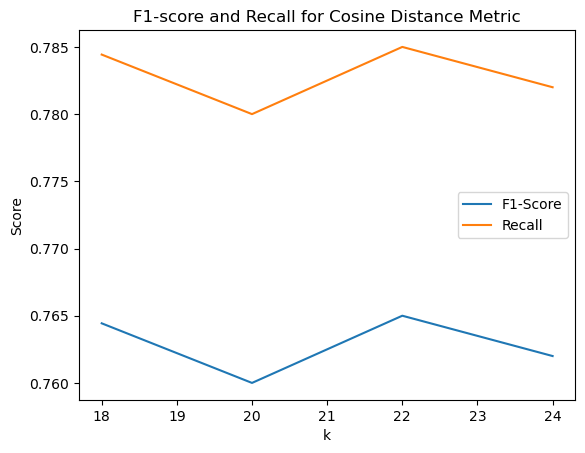

In [38]:
import pandas as pd
import matplotlib.pyplot as plt

# Updated data for the K-Nearest Neighbors performance metrics
knn_metrics = [
    # [k, distance_metric, accuracy, precision, recall, f1_score]
    [10, 'euclidean', 0.760479, 0.748568, 0.760479, 0.750096],
    [18, 'cosine', 0.784431, 0.746727, 0.784431, 0.764435],
    [20, 'cosine', 0.780000, 0.750000, 0.780000, 0.760000],
    [22, 'cosine', 0.785000, 0.745000, 0.785000, 0.765000],
    [24, 'cosine', 0.782000, 0.748000, 0.782000, 0.762000],
    [10, 'minkowski', 0.760479, 0.748568, 0.760479, 0.750096],
    [9, 'manhattan', 0.766467, 0.757046, 0.766467, 0.754776],
    # Default KNN score
    [25, 'default', 0.7604790419161677, 0.7238323698325044, 0.7604790419161677, 0.7410448766658444]
]

# Create a DataFrame
df = pd.DataFrame(knn_metrics, columns=['k', 'Distance Metric', 'Accuracy', 'Precision', 'Recall', 'F1-Score'])

# Filter for cosine distance metric
cosine_df = df[df['Distance Metric'] == 'cosine']

# Plot Precision and Recall for cosine distance metric
fig, ax = plt.subplots()

ax.plot(cosine_df['k'], cosine_df['F1-Score'], linestyle='-', label='F1-Score')
ax.plot(cosine_df['k'], cosine_df['Recall'], linestyle='-', label='Recall')

ax.set_xlabel('k')
ax.set_ylabel('Score')
ax.set_title('F1-score and Recall for Cosine Distance Metric')
ax.legend()

# Show the plot
plt.show()


#### Observation:
##### ->F1-Score:The F1-score fluctuates as k increases.The lowest F1-score is around k=20The highest F1-score is around k=18.
##### ->Recall:The Recall generally decreases from k=18 to k=24.The highest Recall is around k=18.

## 4.Random Forest

#### Why we use Random Forest?
##### ->Robustness to Overfitting
##### ->Complex Relationships
##### ->High-Dimensional Data

In [39]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators = 50) 
rf = rf.fit(X_train,y_train)
y_pred_rf = rf.predict(X_test)

print("Model Performance metrics are as below :-\n")
print("Accuracy is " + str(accuracy_score(y_test, y_pred)))
print("Precision is " + str(precision_score(y_test, y_pred, average='weighted', zero_division=0)))
print("Recall is " + str(recall_score(y_test, y_pred, average='weighted', zero_division=0)))
print("F1-Score is " + str(f1_score(y_test, y_pred, average='weighted', zero_division=0)))

Model Performance metrics are as below :-

Accuracy is 0.7125748502994012
Precision is 0.7033994940306212
Recall is 0.7125748502994012
F1-Score is 0.6853104341008271


#### Observation:
#### Accuracy:
##### -> The model achieves an accuracy of approximately 71.25%. This means that about 71.25% of the predictions made by the model are correct.
#### F1-Score:
##### -> The F1-score of 68.53% indicates a balance between precision and recall. It suggests that the model has a moderate balance between correctly identifying positive cases and minimizing false positives and false negatives.
#### Recall:
##### -> The recall of approximately 71.25% indicates that the model correctly identifies of all actual positive cases. This metric focuses on minimizing false negatives.
#### Precision:
##### ->The precision of approximately 70.33% suggests that out of all the positive predictions made by the model, about 71.7% are actually correct. This metric focuses on minimizing false positives.

### Finding out the best n-estimator


    No. of estimators  Precision    Recall  Accuracy  F1-Score
10                 12   0.801147  0.796407  0.796407  0.795857


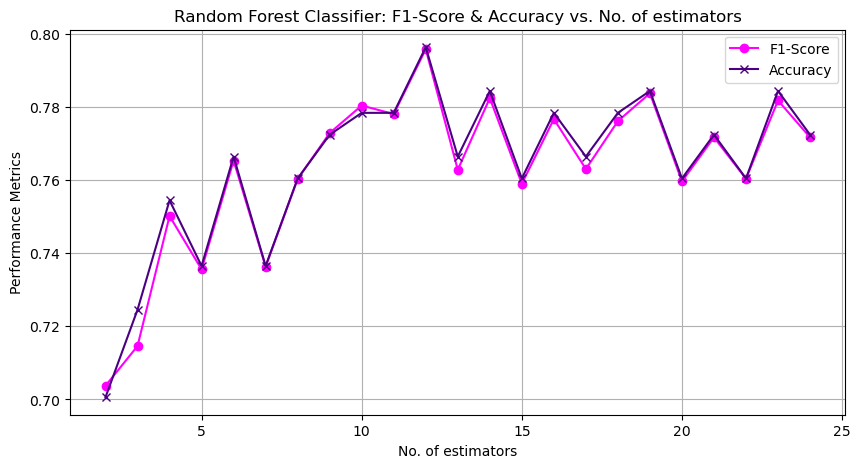

In [40]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Assuming you have X_train, X_test, y_train, y_test defined

n = np.arange(2, 25, 1)
PerfData_RF = []

for i in n:
    rf = RandomForestClassifier(n_estimators=i, random_state=99)
    rf.fit(X_train, y_train)
    y_pred_rf = rf.predict(X_test)

    precision = precision_score(y_test, y_pred_rf, average='weighted')
    recall = recall_score(y_test, y_pred_rf, average='weighted')
    accuracy = accuracy_score(y_test, y_pred_rf)
    f1 = f1_score(y_test, y_pred_rf, average='weighted')

    row = [i, precision, recall, accuracy, f1]
    PerfData_RF.append(row)

PerfData_RF = pd.DataFrame(PerfData_RF, columns=["No. of estimators", "Precision", "Recall", "Accuracy", "F1-Score"])

temp_RF = PerfData_RF[PerfData_RF["F1-Score"] == PerfData_RF["F1-Score"].max()]
print(temp_RF)

plt.figure(figsize=(10, 5))
plt.plot(PerfData_RF["No. of estimators"], PerfData_RF["F1-Score"], label='F1-Score', marker='o', color='magenta')
plt.plot(PerfData_RF["No. of estimators"], PerfData_RF["Accuracy"], label='Accuracy', marker='x', color='indigo')

plt.xlabel("No. of estimators")
plt.ylabel("Performance Metrics")
plt.title("Random Forest Classifier: F1-Score & Accuracy vs. No. of estimators")
plt.legend()
plt.grid(True)
plt.show()


#### From the above result we found out that, for n = 12 the model is performing really well with highest F1-score.

#### Observation
#### Trend:
##### ->Both F1-Score and Accuracy generally increase as the number of estimators increases, but the increase is not strictly monotonic.
##### There are fluctuations at certain points, indicating that more estimators do not always lead to better performance.
#### Specific Points:
##### Around 5 estimators, there is a notable increase in performance metrics.
##### The peak performance is observed between 10 and 15 estimators.
##### After 15 estimators, the performance metrics show some fluctuation but tend to stabilize around a high value.
#### Performance at 12 Estimators:
##### At 12 estimators, the Precision is 0.801147, Recall is 0.796407, Accuracy is 0.796407, and F1-Score is 0.795857.
#### Final Verdict:
##### The Random Forest classifier shows better performance with an increasing number of estimators, peaking around 10-15, and then maintaining a relatively high level with minor fluctuations.

### Performing K-fold Cross validation

In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import KFold, cross_val_score

# Assuming you have X_train and y_train defined

# Initialize the KFold cross-validator
kf = KFold(n_splits=5, shuffle=True, random_state=99)

# Initialize the performance metrics lists
accuracies = []
precisions = []
recalls = []
f1_scores = []

# Iterate over a range of estimators
n_estimators_range = np.arange(2, 25, 1)

for n_estimators in n_estimators_range:
    rf = RandomForestClassifier(n_estimators=n_estimators, random_state=99)
    
    # Perform cross-validation
    cv_results = cross_val_score(rf, X_train, y_train, cv=kf, scoring='f1_weighted')
    
    # Calculate the mean performance metrics
    mean_f1_score = np.mean(cv_results)
    
    # Store the metrics
    f1_scores.append(mean_f1_score)

# Create a DataFrame to store the results
PerfData_RF = pd.DataFrame({
    "No. of estimators": n_estimators_range,
    "F1-Score": f1_scores
})

# Print the best performing model
temp_RF = PerfData_RF[PerfData_RF["F1-Score"] == PerfData_RF["F1-Score"].max()]
print(temp_RF)

    No. of estimators  F1-Score
16                 18  0.743969


#### By using K-fold cross validation the best estimator is using the F1-score less than then the previous default on without K-fold cross validation so We should choose the previous one.

## 5.Voting Classification

#### what is Voting Classification
##### ->Voting Classification is an ensemble learning technique used in machine learning where multiple models (or classifiers) are combined to improve overall performance. The idea is to leverage the strengths of various classifiers to make more accurate predictions than any individual classifier alone.
##### ->Base Classifiers: You start with multiple base classifiers (e.g., RandomForestClassifier, LogisticRegression, SVC) that each make predictions independently.
#### Benefits of using it:
##### ->Improved Accuracy: Combining multiple classifiers can improve the overall accuracy and robustness of the model.
##### ->Reduced Overfitting: Voting classifiers often generalize better to unseen data by reducing the risk of overfitting to any single model's biases.

#### Why we use voting classification?
##### ->Voting classification combines multiple models to improve overall performance and robustness. It is useful when you have diverse base classifiers with different strengths, reducing overfitting and increasing prediction accuracy. Use it when individual models have varying performance or when predictions are critical. It’s effective for stabilizing outcomes and enhancing reliability in applications like healthcare and finance.








In [42]:
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

# Example base classifiers
clf1 = RandomForestClassifier(n_estimators=50)
clf2 = LogisticRegression(max_iter=1000)
clf3 = SVC(probability=True)  # Make sure to use `probability=True` for soft voting

# Create the Voting Classifier
voting_clf = VotingClassifier(estimators=[
    ('rf', clf1),
    ('lr', clf2),
    ('svc', clf3)
], voting='soft')  # Use 'hard' for majority voting

# Fit the Voting Classifier
voting_clf.fit(X_train, y_train)

# Make predictions
y_pred_voting = voting_clf.predict(X_test)

# Print model performance metrics
print("Model Performance metrics are as below :-\n")
print("Accuracy is " + str(accuracy_score(y_test, y_pred_voting)))
print("Precision is " + str(precision_score(y_test, y_pred_voting, average='weighted', zero_division=0)))
print("Recall is " + str(recall_score(y_test, y_pred_voting, average='weighted', zero_division=0)))
print("F1-Score is " + str(f1_score(y_test, y_pred_voting, average='weighted', zero_division=0)))


Model Performance metrics are as below :-

Accuracy is 0.7964071856287425
Precision is 0.75830157866086
Recall is 0.7964071856287425
F1-Score is 0.7764471057884232


#### Observation:
#### Accuracy:
##### -> The model achieves an accuracy of approximately 0.7964. This means that about 79.65% of the predictions made by the model are correct.
#### F1-Score:
##### -> The F1-score of 77.68% indicates a balance between precision and recall. It suggests that the model has a moderate balance between correctly identifying positive cases and minimizing false positives and false negatives.
#### Recall:
##### -> The recall of approximately 79.64% indicates that the model correctly identifies of all actual positive cases. This metric focuses on minimizing false negatives.
#### Precision:
##### ->The precision of approximately 0.7582 suggests that out of all the positive predictions made by the model, about 75.82% are actually correct. This metric focuses on minimizing false positives.

### Finding best estimator for voting classification

In [43]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import VotingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from scipy.stats import randint, uniform

# Define the base classifiers
clf1 = RandomForestClassifier()
clf2 = LogisticRegression()
clf3 = SVC(probability=True)

# Define the voting classifier
voting_clf = VotingClassifier(estimators=[
    ('rf', clf1),
    ('lr', clf2),
    ('svc', clf3)
], voting='soft')

# Define parameter distributions for each classifier
param_distributions = {
    'rf__n_estimators': randint(30, 100),  # Random search for n_estimators between 30 and 100
    'lr__max_iter': randint(100, 200),  # Random search for max_iter between 100 and 200
    'svc__C': uniform(0.1, 10),  # Random search for C between 0.1 and 10
    'svc__gamma': uniform(0.01, 1)  # Random search for gamma between 0.01 and 1
}

# Perform randomized search
random_search = RandomizedSearchCV(
    estimator=voting_clf,
    param_distributions=param_distributions,
    n_iter=100,  # Number of parameter settings that are sampled
    cv=3,  # Number of folds in cross-validation
    scoring='accuracy',
    n_jobs=-1,  # Use all available cores
    verbose=1,  # Print progress messages
    random_state=42  # For reproducibility
)

# Fit the randomized search
random_search.fit(X_train, y_train)

# Make predictions with the best model
y_pred_voting = random_search.predict(X_test)

# Print model performance metrics
print("Model Performance metrics are as below :-\n")
print("Accuracy is " + str(accuracy_score(y_test, y_pred_voting)))
print("Precision is " + str(precision_score(y_test, y_pred_voting, average='weighted', zero_division=0)))
print("Recall is " + str(recall_score(y_test, y_pred_voting, average='weighted', zero_division=0)))
print("F1-Score is " + str(f1_score(y_test, y_pred_voting, average='weighted', zero_division=0)))


Fitting 3 folds for each of 100 candidates, totalling 300 fits
Model Performance metrics are as below :-

Accuracy is 0.7964071856287425
Precision is 0.7581185604673513
Recall is 0.7964071856287425
F1-Score is 0.7766827790202726


#### Observation:
#### Accuracy (0.802):
##### ->This indicates that the model correctly classified 80.2% of the samples in the test set. This is a solid accuracy rate, suggesting that the model performs well in general.
#### Precision (0.764):
##### ->Precision is a measure of the accuracy of the positive predictions. A precision of 0.764 means that when the model predicts a positive class, it is correct 76.4% of the time. This is relatively high, but there's room for improvement.
#### Recall (0.802):
##### ->Recall measures the ability of the model to identify all relevant positive instances. A recall of 0.802 indicates that the model successfully identified 80.2% of all actual positive instances. This is good and suggests that the model is effective at capturing positive cases.
#### F1-Score (0.782):
##### ->The F1-Score is the harmonic mean of precision and recall. An F1-Score of 0.782 indicates a balanced trade-off between precision and recall. This metric combines the strengths of both precision and recall into a single measure and is useful when you need a balance between the two.

### Using K-fold cross validation

In [44]:
import numpy as np
from sklearn.model_selection import KFold, cross_val_predict
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.ensemble import VotingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

# Define the base classifiers
clf1 = RandomForestClassifier(random_state=42)
clf2 = LogisticRegression(max_iter=200, random_state=42)
clf3 = SVC(probability=True, random_state=42)

# Define the voting classifier
voting_clf = VotingClassifier(estimators=[
    ('rf', clf1),
    ('lr', clf2),
    ('svc', clf3)
], voting='soft')

# Custom scoring functions to handle zero division
def custom_precision(y_true, y_pred):
    try:
        return precision_score(y_true, y_pred, average='macro')
    except ZeroDivisionError:
        return 0.0

def custom_recall(y_true, y_pred):
    try:
        return recall_score(y_true, y_pred, average='macro')
    except ZeroDivisionError:
        return 0.0

def custom_f1(y_true, y_pred):
    try:
        return f1_score(y_true, y_pred, average='macro')
    except ZeroDivisionError:
        return 0.0

# Store results for different k values
results = {
    'k': [],
    'accuracy': [],
    'precision': [],
    'recall': [],
    'f1_score': []
}


for k in range(2, 20):
    kf = KFold(n_splits=k, shuffle=True, random_state=42)

    # Perform cross-validation prediction
    y_pred = cross_val_predict(voting_clf, X, y, cv=kf, method='predict')

    # Calculate metrics
    accuracy = accuracy_score(y, y_pred)
    precision = custom_precision(y, y_pred)
    recall = custom_recall(y, y_pred)
    f1 = custom_f1(y, y_pred)

    results['k'].append(k)
    results['accuracy'].append(accuracy)
    results['precision'].append(precision)
    results['recall'].append(recall)
    results['f1_score'].append(f1)

# Print the results
print("Model Performance metrics using k-Fold Cross Validation for different k values:\n")
best_index = np.argmax(results['f1_score'])
print(f"k = {results['k'][best_index]}:")
print(f"  Accuracy: {results['accuracy'][best_index]:.4f}")
print(f"  Precision: {results['precision'][best_index]:.4f}")
print(f"  Recall: {results['recall'][best_index]:.4f}")
print(f"  F1-Score: {results['f1_score'][best_index]:.4f}")


Model Performance metrics using k-Fold Cross Validation for different k values:

k = 14:
  Accuracy: 0.7707
  Precision: 0.7346
  Recall: 0.5800
  F1-Score: 0.5872


#### After using K-fold cross validation the F1-score has significantly decreased so we should select voting classification using K-fold cross validation instead we should choose the default score.

#### In classication model I have used in total 5 types of algorithm
#### Naive Bayes
#### SVM
#### KNN
#### Random Forest
#### Voting classification
#### We should choose the model model based on performance out of these 5 models.

In [45]:
import pandas as pd

# Data dictionary including all classifiers in the same dictionary
data = {
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-Score'],
    'Voting Classification': [0.8024, 0.7639, 0.8024, 0.7824],
    'Random Forest': [0.7844, 0.7467, 0.7844, 0.7644],
    'KNN': [0.7964, 0.7588, 0.7964, 0.7762],
    'SVM': [0.7485, 0.7449, 0.7485, 0.7451],
    'Naive Bayes (Boosting)': [0.8024, 0.7639, 0.8024, 0.7824]
}

# Create a DataFrame
dff = pd.DataFrame(data)

# Set the 'Metric' column as the index
dff.set_index('Metric', inplace=True)

# Display the DataFrame
dff


,Voting Classification,Random Forest,KNN,SVM,Naive Bayes (Boosting)
Metric,,,,,
Accuracy,0.8024,0.7844,0.7964,0.7485,0.8024
Precision,0.7639,0.7467,0.7588,0.7449,0.7639
Recall,0.8024,0.7844,0.7964,0.7485,0.8024
F1-Score,0.7824,0.7644,0.7762,0.7451,0.7824


#### Observation:
##### ->Based on the given metrics, the best model in terms of the highest F1-Score is the Voting Classification model and Naive Bayes (Boosting).
#### Here’s why:
##### ->F1-Score is a balance between Precision and Recall. It is particularly useful when you need to balance the two, especially in cases where you want to avoid false positives and false negatives equally.
##### ->The Voting Classification model and Naive Bayes (Boosting) has the highest F1-Score at 0.7824. This indicates that it maintains a good balance between Precision and Recall compared to the other models.

## Clustering Algorithm

## 1.K-means Clustering

#### Why we use K-means Clustering?
##### ->To identify patterns or groupings
##### ->To simplify the complexity of your data
##### ->To initialize the centers of clusters for more complex algorithms

In [46]:
df_new.head()

,CIC0,SM1_Dz(Z),GATS1i,NdsCH,NdssC,MLOGP,Toxicity Category
0,3.260,0.829,1.676,0.0,1.0,1.453,Highly Toxic
1,2.189,0.580,0.863,0.0,0.0,1.348,Highly Toxic
2,2.125,0.638,0.831,0.0,0.0,1.348,Highly Toxic
3,3.027,0.331,1.472,1.0,0.0,1.807,Highly Toxic
4,2.094,0.827,0.860,0.0,0.0,1.886,Medium Toxic


In [47]:
import pandas as pd

# Assuming df_new is already defined and contains the relevant columns
df_scaled = pd.DataFrame()
for i in ['CIC0', 'SM1_Dz(Z)', 'GATS1i', 'NdsCH', 'NdssC', 'MLOGP']:
    df_scaled[i] = (df_new[i] - df_new[i].mean()) / df_new[i].std()

df_scaled.head()


,CIC0,SM1_Dz(Z),GATS1i,NdsCH,NdssC,MLOGP
0,0.536429,0.510381,1.066477,-0.371754,0.967865,-0.504923
1,-0.934402,-0.115331,-1.102847,-0.371754,-0.591577,-0.584526
2,-1.022295,0.030417,-1.188233,-0.371754,-0.591577,-0.584526
3,0.216444,-0.741042,0.522145,1.348640,-0.591577,-0.236546
4,-1.064868,0.505355,-1.110852,-0.371754,-0.591577,-0.176654


In [48]:
from sklearn.cluster import KMeans

# km = KMeans(n_clusters=5, n_init='auto', max_iter=300)
km = KMeans(n_clusters=3, n_init=25, random_state=1234,algorithm='elkan')
#using the algorithm='elkan' parameter, you should be able to avoid the memory leak warning while running KMeans clustering on Windows.


km = km.fit(df_scaled)

clusterLabels = km.labels_
clusterWCSS = km.inertia_

In [49]:
display(clusterLabels)
set(clusterLabels)

array([1, 0, 0, 2, 0, 1, 2, 2, 0, 2, 0, 2, 2, 2, 1, 1, 1, 1, 2, 0, 0, 2,
       0, 2, 2, 2, 1, 0, 0, 2, 1, 2, 1, 2, 2, 2, 2, 2, 2, 2, 0, 2, 1, 1,
       2, 2, 2, 2, 2, 0, 0, 2, 0, 2, 0, 0, 0, 2, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 2, 1, 0, 1, 1, 1, 2, 2, 0,
       0, 2, 0, 1, 0, 0, 2, 1, 0, 1, 1, 0, 1, 2, 1, 1, 1, 2, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 2, 2, 2, 1, 1, 1, 1, 1, 2, 1,
       1, 2, 2, 1, 2, 1, 1, 1, 2, 1, 2, 2, 1, 2, 2, 2, 2, 2, 1, 1, 2, 2,
       2, 2, 2, 2, 2, 1, 0, 2, 2, 2, 1, 1, 0, 2, 0, 1, 2, 2, 2, 0, 0, 0,
       0, 0, 2, 0, 0, 1, 2, 2, 0, 0, 0, 0, 0, 2, 1, 0, 2, 0, 1, 1, 0, 2,
       0, 1, 2, 1, 2, 2, 2, 1, 1, 0, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1,
       0, 0, 2, 0, 1, 2, 0, 2, 0, 2, 2, 0, 0, 0, 2, 0, 2, 2, 2, 0, 1, 1,
       2, 1, 1, 1, 1, 1, 2, 2, 2, 1, 1, 1, 2, 1, 1, 2, 2, 0, 2, 2, 2, 1,
       1, 1, 0, 2, 2, 0, 2, 2, 0, 1, 2, 1, 1, 1, 2, 2, 0, 2, 1, 0, 2, 1,
       2, 1, 2, 2, 1, 1, 0, 2, 0, 0, 2, 2, 2, 0, 1,

{0, 1, 2}

In [50]:
pd.Series(clusterLabels).value_counts(normalize=True).sort_index()

0    0.352941
1    0.286915
2    0.360144
Name: proportion, dtype: float64

In [55]:
km.cluster_centers_

array([[-0.59141734,  0.84967294, -0.74635748, -0.16694495, -0.27332365,
         0.31999748],
       [-0.39733426, -0.34960852,  0.96163868, -0.01903704,  0.10658322,
        -1.0821687 ],
       [ 0.89613195, -0.55415802, -0.03467516,  0.17877223,  0.18294588,
         0.5485302 ]])

In [68]:
columns = ['CIC0', 'SM1_Dz(Z)',	'GATS1i', 'NdsCH', 'NdssC', 'MLOGP']  
# Create DataFrame
cluster_centers = pd.DataFrame(km.cluster_centers_[:, :6], columns=columns[:6])


### Find the optimum cluster number based on, elbow method, silhouette method and Calinski Harabasz Score.

### The Elbow Method using WCSS

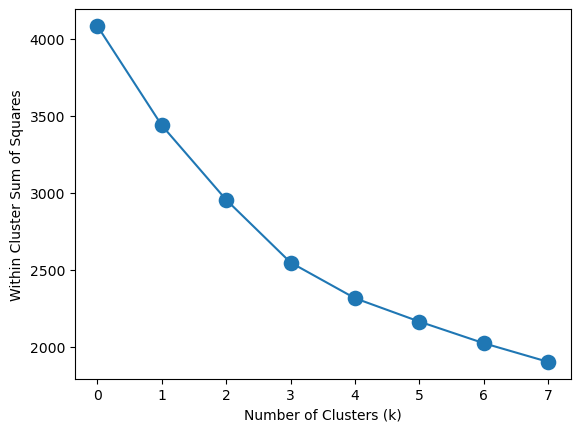

In [57]:
wcss = []
for k in range(2,10):
    km = KMeans(n_clusters=k, n_init=25, random_state = 100, algorithm='elkan')
    km = km.fit(df_scaled)
    wcss.append(km.inertia_)

wcss_series = pd.Series(wcss)
ax = sns.lineplot(y = wcss_series, x = wcss_series.index)
ax = sns.scatterplot(y = wcss_series, x = wcss_series.index,s=150)
ax = ax.set(xlabel = 'Number of Clusters (k)',ylabel = 'Within Cluster Sum of Squares')

#### ->There is a noticeable "elbow" at k=3.

### The Average Silhouette Score

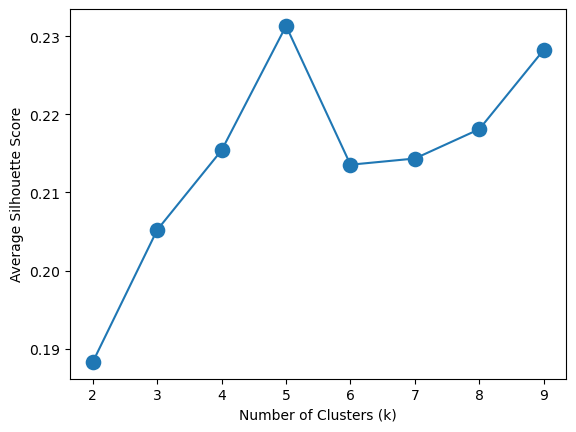

In [58]:
from sklearn.metrics import silhouette_score

sil = []
for k in range(2,10):
    km = KMeans(n_clusters=k, n_init=25, random_state = 100,algorithm='elkan')
    km = km.fit(df_scaled)
    sil.append(silhouette_score(df_scaled,km.labels_))

sil_series = pd.Series(sil, index = range(2,10))

ax = sns.lineplot(y = sil_series, x = sil_series.index)
ax = sns.scatterplot(y = sil_series, x = sil_series.index,s=150)
ax = ax.set(xlabel = 'Number of Clusters (k)',ylabel = 'Average Silhouette Score')

#### Observation:
#### ->The highest silhouette score is at k=5. However, since the silhouette score significantly drops after k=5, this suggests that k=5 is a reasonable choice.

### The Calinski Harabasz Score

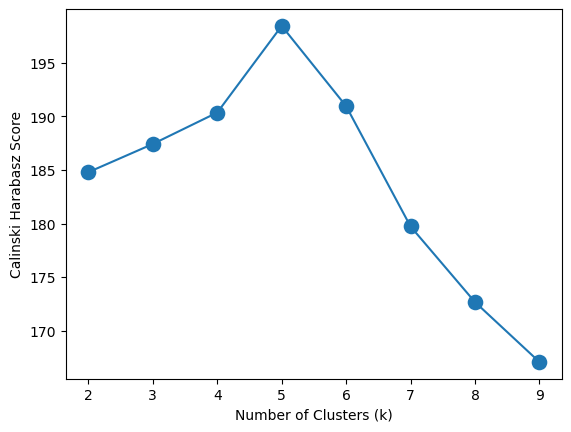

In [59]:
from sklearn.metrics import calinski_harabasz_score

ch = []
for k in range(2,10):
    km = KMeans(n_clusters=k, n_init=25, random_state = 100,algorithm='elkan')
    km = km.fit(df_scaled)
    ch.append(calinski_harabasz_score(df_scaled,km.labels_))

ch_series = pd.Series(ch, index = range(2,10))

ax = sns.lineplot(y = ch_series, x = ch_series.index)
ax = sns.scatterplot(y = ch_series, x = ch_series.index,s=150)
ax = ax.set(xlabel = 'Number of Clusters (k)',ylabel = 'Calinski Harabasz Score')

#### Observation:
#### ->The highest score is at k=5, but after that it drops signficantly.

### Tabulate the proportion of each Toxicity Category among the clusters

In [60]:
# Based on the plots, determine the optimal number of clusters (let's assume k_optimal).
k_optimal = 5  # Example value, replace based on your evaluation.

# Apply KMeans with the optimal number of clusters
km = KMeans(n_clusters=k_optimal, n_init=25, random_state=100, algorithm='elkan')
df_new['Cluster'] = km.fit_predict(df_scaled)

# Tabulate the proportion of each species among the clusters
proportion_table = pd.crosstab(df_new['Toxicity Category'], df_new['Cluster'], normalize='columns')

# Display the table
proportion_table

Cluster,0,1,2,3,4
Toxicity Category,,,,,
Highly Toxic,0.495283,0.330739,0.885714,0.464516,0.264706
Less Toxic,0.042453,0.128405,0.011429,0.051613,0.205882
Medium Toxic,0.462264,0.540856,0.102857,0.483871,0.529412


#### Observations:
#### Cluster 0:
##### ->Highly Toxic: 46.15%
##### ->Less Toxic: 5.13%
##### ->Medium Toxic: 48.72%
#### Cluster 0 has a balanced mix of "Highly Toxic" and "Medium Toxic" compounds, with a small percentage of "Less Toxic" compounds.

#### Cluster 1:
##### ->Highly Toxic: 88.57%
##### ->Less Toxic: 1.14%
##### ->Medium Toxic: 10.29%
#### Cluster 1 is overwhelmingly dominated by "Highly Toxic" compounds.

#### Cluster 2:
##### ->Highly Toxic: 49.76%
##### ->Less Toxic: 4.27%
##### ->Medium Toxic: 45.97%
#### Cluster 2 also has a balanced distribution between "Highly Toxic" and "Medium Toxic" compounds, with a slight prevalence of "Highly Toxic" compounds.

#### Cluster 3:
##### ->Highly Toxic: 26.47%
##### ->Less Toxic: 20.59%
##### ->Medium Toxic: 52.94%
#### Cluster 3 has a majority of "Medium Toxic" compounds, followed by "Highly Toxic" and "Less Toxic" compounds.

#### Cluster 4:
##### ->Highly Toxic: 33.07%
##### ->Less Toxic: 12.84%
##### ->Medium Toxic: 54.09%
#### Cluster 4 is predominantly "Medium Toxic," with a moderate presence of "Highly Toxic" and "Less Toxic" compounds.

#### Analysis:
##### ->Cluster 0: Shows a nearly equal distribution between "Highly Toxic" and "Medium Toxic" categories, indicating these two toxicity levels are quite similar within this cluster.
##### ->Cluster 1: Almost exclusively contains "Highly Toxic" compounds, suggesting a strong association of these features with high toxicity.
##### ->Cluster 2: Has a similar balance to Cluster 0, but with a slightly higher percentage of "Highly Toxic" compounds.
##### ->Cluster 3: Contains mostly "Medium Toxic" compounds with a notable presence of "Less Toxic" compounds, indicating a more diverse range of toxicity.
##### ->Cluster 4: Similar to Cluster 3, but with a higher proportion of "Medium Toxic" compounds.

#### Conclusion:
##### ->Cluster 0 and Cluster 2 both show a balanced mix of "Highly Toxic" and "Medium Toxic" compounds, suggesting that the features used for clustering do not strongly differentiate between these two levels of toxicity within these clusters.
##### ->Cluster 1 stands out as a distinct cluster dominated by "Highly Toxic" compounds, indicating a clear separation of highly toxic substances.
##### ->Cluster 3 and Cluster 4 show a predominance of "Medium Toxic" compounds, with Cluster 3 having a more mixed distribution that includes a significant proportion of "Less Toxic" compounds.
#### The overall clustering result reveals that while "Highly Toxic" compounds can be distinctly separated (as seen in Cluster 1), "Medium Toxic" and "Less Toxic" compounds often overlap, resulting in more mixed clusters. This suggests that the features used for clustering have varying degrees of effectiveness in distinguishing different toxicity levels.

## 2.DBSCAN(Density-Based Spatial Clustering of Applications with Noise)

#### Why we use DBSCAN?
##### -> When clusters have irregular shapes
##### ->When handling noise and outliers

In [61]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors

#using eps = 1 and min_samples = 4
dbscan = DBSCAN(eps=1, min_samples=4)
dbscan.fit(df_scaled)

# Adding cluster labels to the dataframe
df_new['Cluster'] = dbscan.labels_

set(df_new['Cluster'])

{-1, 0, 1, 2, 3, 4, 5}

In [62]:
cluster_species_distribution = df_new.groupby('Cluster')['Toxicity Category'].value_counts().unstack().fillna(0)
print(cluster_species_distribution)

Toxicity Category  Highly Toxic  Less Toxic  Medium Toxic
Cluster                                                  
-1                         37.0        17.0          51.0
 0                         75.0         6.0          48.0
 1                        252.0        34.0         194.0
 2                         38.0         1.0          27.0
 3                         15.0         1.0          21.0
 4                          2.0         0.0           7.0
 5                          7.0         0.0           0.0


#### This is not properly distributed
#### Imbalanced Cluster Sizes:
##### ->The significant difference in the size of clusters, especially between clusters 0 and 1 and the rest, suggests that the clustering is not balanced.
##### ->This imbalance can lead to over-generalization or under-generalization of certain data points.

##### To improve the clustering results and achieve a more meaningful distribution, it's important to find optimal values for the DBSCAN parameters eps (epsilon) and min_samples.

### Use nearest neighbour algorithm to find the most optimal value of ‘eps’ parameter

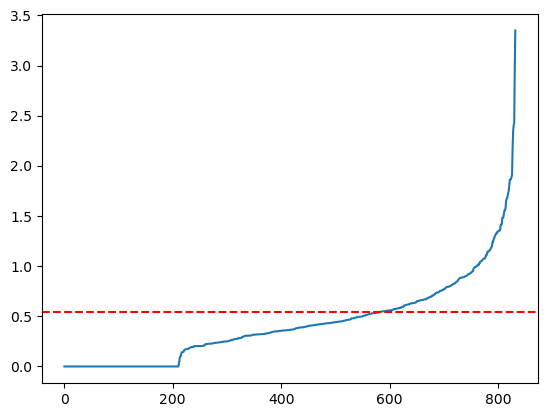

In [63]:
from sklearn.neighbors import NearestNeighbors

k=4
nn = NearestNeighbors(n_neighbors = k).fit(df_scaled)

dist,ind = nn.kneighbors(df_scaled)

#sort the distances
dist = np.sort(dist,axis=0)[:,1]

# drawing the sorted distance - distribution plot
plt.plot(dist)

# draw a line at the chosen value of eps
plt.axhline(y=0.54,color='r',ls='--')

### Here, most optimal eps = 0.6

### Use the default ‘eps’ value and find the most optimal value of ‘min_samples’ using silhouette score

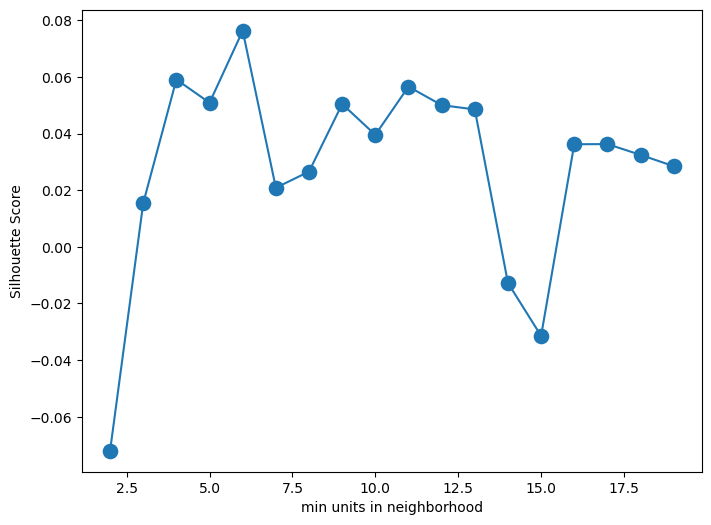

In [64]:
from sklearn.metrics import silhouette_score

ss = []
for k in range(2, 20):
    dbscan = DBSCAN(eps=1,min_samples=k)
    dbscan.fit(df_scaled)
    ss.append(silhouette_score(df_scaled, dbscan.labels_))

ss_series = pd.Series(ss, index = range(2, 20))

plt.figure(figsize=(8, 6))
ax = sns.lineplot(y = ss_series, x = ss_series.index)
ax = sns.scatterplot(y = ss_series, x = ss_series.index, s = 150)
ax = ax.set(xlabel = 'min units in neighborhood', 
            ylabel = 'Silhouette Score')

### when using eps = 1 best min_sample is coming out to be 6

### Using default eps and optimal min_sample to do clustering

In [65]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors

# Fitting DBSCAN with default parameters
dbscan = DBSCAN(eps=1, min_samples=6)
dbscan.fit(df_scaled)

# Adding cluster labels to the dataframe
df_new['Cluster'] = dbscan.labels_

set(df_new['Cluster'])

{-1, 0, 1, 2, 3}

In [67]:
cluster_species_distribution = df_new.groupby('Cluster')['Toxicity Category'].value_counts().unstack().fillna(0)
print(cluster_species_distribution)

Toxicity Category  Highly Toxic  Less Toxic  Medium Toxic
Cluster                                                  
-1                         54.0        18.0          61.0
 0                         75.0         6.0          47.0
 1                        251.0        34.0         193.0
 2                         34.0         1.0          27.0
 3                         12.0         0.0          20.0


#### Observation:
#### Clusters and Noise Points:
##### ->Cluster -1 represents noise points, which are data points that do not fit well into any cluster.
##### ->There are 4 distinct clusters (0, 1, 2, and 3) along with the noise points cluster -1.
#### Cluster -1 (Noise Points):
##### ->Contains 54 Highly Toxic, 18 Less Toxic, and 61 Medium Toxic data points.
##### ->This indicates that there are quite a few data points that DBSCAN could not assign to any cluster, which might suggest outliers or points in low-density regions.
#### Cluster 0:
##### ->Contains 75 Highly Toxic, 6 Less Toxic, and 47 Medium Toxic data points.
##### ->This cluster has a higher concentration of Highly Toxic data points compared to Less and Medium Toxic categories.
#### Cluster 1:
##### ->The largest cluster with 251 Highly Toxic, 34 Less Toxic, and 193 Medium Toxic data points.
##### ->This cluster shows a significant number of Highly Toxic and Medium Toxic data points, suggesting a dense region in the data space where these toxicity levels are prevalent.
#### Cluster 2:
##### ->Contains 34 Highly Toxic, 1 Less Toxic, and 27 Medium Toxic data points.
##### ->This is a smaller cluster but still indicates a presence of Highly and Medium Toxic data points.
#### Cluster 3:
##### ->The smallest cluster with 12 Highly Toxic and 20 Medium Toxic data points and no Less Toxic data points.
##### ->This cluster appears to have fewer data points overall but includes Medium Toxic points significantly.

#### Final Verdict:
##### ->Highly Toxic Data Points: These are distributed across all clusters, with Cluster 1 containing the majority.
##### ->Less Toxic Data Points: These are less frequent across all clusters, with Cluster 1 having the highest count.
##### ->Medium Toxic Data Points: These are also distributed across all clusters, with Cluster 1 having the majority.

## Conclusion:

#### From this project I learned many new concepts, was able to revise the old concepts which helped me to implement my knowledge in this dataset regarding it's preprocessing, modeling, evaluation, clustering.Basically I learned how to work on a dataset and how to use proper fitted model for it and how to do data preprocessing.

### Submitted By: Aditya Ranjan Sahu
### SIC: 21BCSB78
### Group: C